# Описание проекта

## Вводная

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».  
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

## Задача

Нужно создать две прогнозные модели для отбора бурёнок в поголовье:  
Первая будет прогнозировать возможный удой коровы (целевой признак Удой);  
Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).  
С помощью модели нужно отобрать коров по двум критериям:  
средний удой за год — не менее 6000 килограммов;  
молоко должно быть вкусным.  

In [1]:
# !pip install missingno -q
# !pip install phik -q

# Подготовка к работе

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
import missingno as msno
import itertools

from IPython.display import display, HTML
from phik import phik_matrix
from scipy import stats as st
from scipy.stats import binom, norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report
)

# красивые выводы
sns.set()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# сделаем функцию оценки пропусков в датасетах
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)

In [4]:
# функция для обработки пробелов
def process_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = ' '.join(s.split())
    return s

In [5]:
# замена пробелов на нижнее подчеркинвание в названии столбцов
def replace_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = '_'.join(s.split())
    return s

In [6]:
# форматирования текста
def format_display(text):
    return HTML(f"<span style='font-size: 1.5em; font-weight: bold; font-style: italic;'>{text}</span>")

In [7]:
def check_data(data):
    # приведем все к нижнему регистру
    data.columns = data.columns.str.lower()
    
    # удалим лишние пробелы в строках
    data = data.applymap(process_spaces)  # обновляем DataFrame

    # и в названии столбцов
    data.columns = [replace_spaces(col) for col in data.columns]
    
    # общая информация 
    display(format_display("Общая информация базы данных"))
    display(data.info())
    
    # проверка дубликатов
#     display(format_display("Проверим дубликаты и удалим, если есть"))
#     num_duplicates = data.duplicated().sum()
#     display(num_duplicates)
    
#     if num_duplicates > 0:
#         display("Удаляем")
#         data = data.drop_duplicates(keep='first').reset_index(drop=True)  # обновляем DataFrame
#     else:
#         display("Дубликаты отсутствуют")

    # 5 строк
    display(format_display("5 случайных строк"))
    display(data.sample(5))
    
    # пропуски
    display(format_display("Число пропусков в базе данных"))
    display(missing_data(data))

    # проверка на наличие пропусков
    if data.isnull().sum().sum() > 0:
        display(format_display("Визуализация пропусков"))
        msno.bar(data)
        plt.show()
        
    # средние характеристики
    display(format_display("Характеристики базы данных"))
    display(data.describe().T)
    
    return data  # возвращаем измененные данные


In [8]:
def check_normal_quant_features(data, drop=None):
    # берем количественные признаки
    quantitative_features = data.select_dtypes(include=['float64', 'int64']).columns
    
    # дропаем указанные столбцы, если они есть
    if drop is not None:
        quantitative_features = quantitative_features.drop(drop)

    # настраиваем график
    n_features = len(quantitative_features)
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols

    plt.figure(figsize=(15, n_rows * 4))

    # построение гистограмм и тестирование на нормальность
    for i, feature in enumerate(quantitative_features):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.hist(data[feature], bins=30, edgecolor='black', density=True)
        plt.title(feature)
        plt.xlabel('Значение')
        plt.ylabel('Плотность')

        # используем Тест Шапиро-Уилка
        shapiro_stat, p_value = stats.shapiro(data[feature])

        # определяем распределение
        if p_value > 0.05:
            distribution = "похоже на нормальное"
            color = 'green'
        else:
            distribution = "не нормальное"
            color = 'red'

        # добавим результаты теста
        plt.annotate(f'p-значение: {p_value:.3f}\nРаспределение: {distribution}', 
                     xy=(0.5, 0.9), 
                     xycoords='axes fraction', 
                     ha='center', 
                     fontsize=10, 
                     bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey'))

        # и покажем как идет распределение
        x = np.linspace(data[feature].min(), data[feature].max(), 100)
        y = stats.norm.pdf(x, data[feature].mean(), data[feature].std())
        plt.plot(x, y, color=color, linewidth=2)

    plt.tight_layout()
    plt.show()

In [9]:
def check_categorical_features(data):
    # Автоматически определяем категориальные признаки
    categorical_features = data.select_dtypes(include=['object', 'category']).columns
    
    # Определяем количество графиков и создаем фигуру
    num_features = len(categorical_features)
    num_cols = 2
    num_rows = (num_features + 1) // num_cols  # Количество строк
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
    axes = axes.flatten()  # Упрощаем доступ к осям

    for i, feature in enumerate(categorical_features):
        # Частотный анализ
        counts = data[feature].value_counts()
        
        # Визуализация
        counts.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Распределение по {feature}')
        axes[i].set_xlabel('Категории')
        axes[i].set_ylabel('Частота')
        axes[i].tick_params(axis='x', rotation=45)

    # Убираем пустые подграфики, если они есть
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [10]:
def get_scatterplot(categorical_col):
    # выделим количественные признаки
    quantitative_cols = ['удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'жирность_%', 'белок_%']

    # строим диаграммы рассеяния
    for col in quantitative_cols:
        if col != 'удой_кг':  # исключаем график удой / удой
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=ferma_main, x='удой_кг', y=col, hue=categorical_col, palette='viridis')
            plt.title(f'Диаграмма рассеяния: Удой, кг vs {col}')
            plt.xlabel('Удой, кг')
            plt.ylabel(col)
            plt.legend(title=categorical_col)
            plt.show()

            # выводы для каждой категории
            correlation_summary = ferma_main.groupby(categorical_col).apply(
                lambda group: group[['удой_кг', col]].corr().iloc[0, 1]
            ).reset_index(name='correlation')

            for index, row in correlation_summary.iterrows():
                correlation = row['correlation']
                category = row[categorical_col]

                # определение силы корреляции
                if abs(correlation) < 0.25:
                    strength = "низкая"
                elif 0.25 <= abs(correlation) < 0.75:
                    strength = "средняя"
                else:
                    strength = "высокая"

                if correlation > 0:
                    display(f'Существует положительная корреляция ({strength}) между удоем и {col} для категории {category} (коэффициент: {correlation:.2f}).')
                elif correlation < 0:
                    display(f'Существует отрицательная корреляция ({strength}) между удоем и {col} для категории {category} (коэффициент: {correlation:.2f}).')
                else:
                    display(f'Нет значимой корреляции между удоем и {col} для категории {category}.')

            # анализ зависимости
            scatter_data = ferma_main[['удой_кг', col]].dropna()
            if len(scatter_data) > 1:
                # линейная зависимость
                slope, intercept = np.polyfit(scatter_data['удой_кг'], scatter_data[col], 1)
                fitted_line = slope * scatter_data['удой_кг'] + intercept
                residuals = scatter_data[col] - fitted_line

                std_residuals = np.std(residuals)
                std_col = np.std(scatter_data[col])

                # Определяем тип зависимости
                if std_residuals < 0.1 * std_col:
                    dependency_type = "линейная"
                    additional_info = ""
                else:
                    dependency_type = "нелинейная"
                    percent_deviation = (std_residuals / std_col) * 100
                    additional_info = f", стандартное отклонение остатков больше 10% ({percent_deviation:.2f}%) от стандартного отклонения {col}"

                display(f'Тип зависимости между удоем и {col}: {dependency_type} (стандартное отклонение остатков: {std_residuals:.2f}, стандартное отклонение {col}: {std_col:.2f}{additional_info}).')

    # анализ категорий
    category_summary = ferma_main.groupby(categorical_col).agg({
        'удой_кг': 'median',
        'эке': 'median',
        'сырой_протеин_г': 'median',
        'спо': 'median',
        'жирность_%': 'mean',
        'белок_%': 'mean'
    }).reset_index()

    display("Средние значения по категориям:")
    display(category_summary)

    best_category = category_summary.loc[category_summary['удой_кг'].idxmax()]
    display(f"Наиболее выгодная категория по удою: {best_category[categorical_col]} с удоем {best_category['удой_кг']:.2f} кг.")

# Загрузка данных

In [11]:
ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', delimiter=';', decimal = ',')
ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', delimiter=';', decimal = ',')
cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', delimiter=';', decimal = ',')

#  Предобработка данных

## Оценка данных в базах

In [12]:
ferma_main = check_data(ferma_main)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   удой,_кг                               634 non-null    int64  
 2   эке_(энергетическая_кормовая_единица)  634 non-null    float64
 3   сырой_протеин,_г                       634 non-null    int64  
 4   спо_(сахаро-протеиновое_соотношение)   634 non-null    float64
 5   порода                                 634 non-null    object 
 6   тип_пастбища                           634 non-null    object 
 7   порода_папы_быка                       634 non-null    object 
 8   жирность,%                             634 non-null    float64
 9   белок,%                                634 non-null    float64
 10  вкус_молока                            634 non-null    object 
 11  возрас

None

id  удой,_кг  эке_(энергетическая_кормовая_единица)  сырой_протеин,_г  \
370  371      6789                                  15.70              1773   
127  128      6623                                  15.50              2108   
597  598      5844                                  15.50              1872   
498  499      5988                                  13.30              1784   
615  616      6805                                  14.90              1863   

     спо_(сахаро-протеиновое_соотношение)           порода тип_пастбища  \
370                                  0.94  РефлешнСоверинг    Холмистое   
127                                  0.94   Вис Бик Айдиал    Холмистое   
597                                  0.89   Вис Бик Айдиал    Холмистое   
498                                  0.85  РефлешнСоверинг    Холмистое   
615                                  0.93  РефлешнСоверинг    Холмистое   

    порода_папы_быка  жирность,%  белок,% вкус_молока      возраст  
370           Айдиал        3.72     3.07      вкусно  более_2_лет  
127          Соверин        3.73     3.08      вкусно  более_2_лет  
597          Соверин        3.64     3.08      вкусно  более_2_лет  
498           Айдиал        3.62     3.08   не вкусно  более_2_лет  
615           Айдиал        3.71     3.08   не вкусно  более_2_лет

Series([], dtype: int64)

None

count    mean     std     min     25%  \
id                                    634.00  317.46  183.10    1.00  159.25   
удой,_кг                              634.00 6187.03 1638.40 5204.00 5751.75   
эке_(энергетическая_кормовая_единица) 634.00   14.54    1.30   10.90   13.50   
сырой_протеин,_г                      634.00 1922.68  182.39 1660.00 1772.25   
спо_(сахаро-протеиновое_соотношение)  634.00    0.91    0.03    0.84    0.89   
жирность,%                            634.00    3.60    0.17    2.99    3.59   
белок,%                               634.00    3.08    0.00    3.07    3.07   

                                          50%     75%      max  
id                                     317.50  475.75   629.00  
удой,_кг                              6130.50 6501.00 45616.00  
эке_(энергетическая_кормовая_единица)   14.70   15.60    16.80  
сырой_протеин,_г                      1880.50 2058.75  2349.00  
спо_(сахаро-протеиновое_соотношение)     0.93    0.94     0.96  
жирность,%                               3.65    3.72     3.75  
белок,%                                  3.08    3.08     3.08

In [13]:
display(format_display("Проверим дубликаты и удалим, если есть"))
num_duplicates = ferma_main.duplicated().sum()
display(num_duplicates)
    
if num_duplicates > 0:
    display("Удаляем")
    ferma_main = ferma_main.drop_duplicates(keep='first').reset_index(drop=True)  # обновляем DataFrame
else:
    display("Дубликаты отсутствуют")

5

'Удаляем'

In [14]:
# проверим неявные дубликаты в категориальных признаках
display(ferma_main['порода'].unique())
display(ferma_main['тип_пастбища'].unique())
display(ferma_main['порода_папы_быка'].unique())

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

База ferma_main:  
1) надо привести типа данных к нормальным  
2) изменить названия столбцов  
3) значения столбцов порода, тип_пастбища, порода_папы_быка, вкус_молока, возраст - категоризировать для последующего обучения  
4) скорректировать неявные дубликаты в столбце тип_пастбища, вместо Равнинные сделаем Равнинное  
5) скорректировать неявные дубликаты в столбце порода_папы_быка, вместо Айдиалл сделаем Айдиал  



In [15]:
ferma_dad = check_data(ferma_dad)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

id  имя_папы
18    19  Соловчик
386  387  Соловчик
310  311     Барин
470  471  Соловчик
277  278     Барин

Series([], dtype: int64)

None

count   mean    std  min    25%    50%    75%    max
id 629.00 315.00 181.72 1.00 158.00 315.00 472.00 629.00

In [16]:
# проверим тут дубликаты
display(format_display("Проверим дубликаты и удалим, если есть"))
num_duplicates = ferma_dad.duplicated().sum()
display(num_duplicates)
    
if num_duplicates > 0:
    display("Удаляем")
    ferma_dad = ferma_dad.drop_duplicates(keep='first').reset_index(drop=True)  # обновляем DataFrame
else:
    display("Дубликаты отсутствуют")

0

'Дубликаты отсутствуют'

In [17]:
ferma_dad['имя_папы'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

База ferma_dad:
1) категоризировать значения столбца имя_папы

In [18]:
cow_buy = check_data(cow_buy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   порода                   20 non-null     object 
 1   тип_пастбища             20 non-null     object 
 2   порода_папы_быка         20 non-null     object 
 3   имя_папы                 20 non-null     object 
 4   текущая_жирность,%       20 non-null     float64
 5   текущий_уровень_белок,%  20 non-null     float64
 6   возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

порода тип_пастбища порода_папы_быка  имя_папы  \
13   Вис Бик Айдиал    холмистое          Соверин     Барин   
3   РефлешнСоверинг    холмистое           Айдиал    Буйный   
5   РефлешнСоверинг    равнинное          Соверин  Геркулес   
18   Вис Бик Айдиал    равнинное          Соверин    Буйный   
14  РефлешнСоверинг    равнинное          Соверин     Барин   

    текущая_жирность,%  текущий_уровень_белок,%      возраст  
13                3.42                     3.08  менее_2_лет  
3                 3.40                     3.06  более_2_лет  
5                 3.63                     3.05  менее_2_лет  
18                3.34                     3.07  более_2_лет  
14                3.59                     3.07  более_2_лет

Series([], dtype: int64)

None

count  mean  std  min  25%  50%  75%  max
текущая_жирность,%       20.00  3.58 0.13 3.34 3.51 3.59 3.65 3.77
текущий_уровень_белок,%  20.00  3.07 0.01 3.05 3.06 3.07 3.08 3.08

In [19]:
# проверим тут дубликаты
display(format_display("Проверим дубликаты и удалим, если есть"))
num_duplicates = cow_buy.duplicated().sum()
display(num_duplicates)

4

но! в этой базе нет уникальных ID, как следствие это могут быть не дубликаты, а уникальные коровы с одинаковыми характеристиками, поэтому - оставляем

In [20]:
# проверим неявные дубликаты в категориальных признаках
display(cow_buy['порода'].unique())
display(cow_buy['тип_пастбища'].unique())
display(cow_buy['порода_папы_быка'].unique())
display(cow_buy['имя_папы'].unique())

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

array(['холмистое', 'равнинное'], dtype=object)

array(['Айдиал', 'Соверин'], dtype=object)

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

База cow_buy:  

1) надо привести типа данных к нормальным  
2) изменить названия столбцов  
3) значения столбцов порода, тип_пастбища, порода_папы_быка, имя_папы, возраст - категоризировать для последующего обучения  

## Выводы после оценки

Общие выводы:  
1) изменить названия столбцов  
2) надо привести типы данных к нормальным  
3) можно объединить базы ferma_main и ferma_dad т.к. они совпадают по размерности + это может увеличить точность модели  

База ferma_main:  
Скорректировать неявные дубликаты в столбце тип_пастбища, вместо Равнинные сделаем Равнинное  
Значения столбцов порода, тип_пастбища, порода_папы_быка, вкус_молока, возраст - категоризировать для последующего обучения  

База ferma_dad:  
Категоризировать значения столбца имя_папы  

База cow_buy:  
Значения столбцов порода, тип_пастбища, порода_папы_быка, имя_папы, возраст - категоризировать для последующего обучения  

### Исправим названия столбцов в базах

In [21]:
ferma_main = ferma_main.rename(columns={"удой,_кг": "удой_кг"})
ferma_main = ferma_main.rename(columns={"эке_(энергетическая_кормовая_единица)": "эке"})
ferma_main = ferma_main.rename(columns={"сырой_протеин,_г": "сырой_протеин_г"})
ferma_main = ferma_main.rename(columns={"спо_(сахаро-протеиновое_соотношение)": "спо"})
ferma_main = ferma_main.rename(columns={"жирность,%": "жирность_%"})
ferma_main = ferma_main.rename(columns={"белок,%": "белок_%"})

cow_buy = cow_buy.rename(columns={"текущая_жирность,%": "жирность_%"})
cow_buy = cow_buy.rename(columns={"текущий_уровень_белок,%": "белок_%"})

In [22]:
display(ferma_main.info())
display(cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                629 non-null    int64  
 1   удой_кг           629 non-null    int64  
 2   эке               629 non-null    float64
 3   сырой_протеин_г   629 non-null    int64  
 4   спо               629 non-null    float64
 5   порода            629 non-null    object 
 6   тип_пастбища      629 non-null    object 
 7   порода_папы_быка  629 non-null    object 
 8   жирность_%        629 non-null    float64
 9   белок_%           629 non-null    float64
 10  вкус_молока       629 non-null    object 
 11  возраст           629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   порода            20 non-null     object 
 1   тип_пастбища      20 non-null     object 
 2   порода_папы_быка  20 non-null     object 
 3   имя_папы          20 non-null     object 
 4   жирность_%        20 non-null     float64
 5   белок_%           20 non-null     float64
 6   возраст           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

### Исправим типы данных

In [23]:
# # функция для преобразования столбцов
# def convert_columns(data, columns):
#     for column in columns:
#         data[column] = data[column].str.replace(',', '.').astype('float32')

# # список столбцов для ferma_main
# ferma_columns = ['эке', 'спо', 'жирность_%', 'белок_%']
# convert_columns(ferma_main, ferma_columns)
# display(ferma_main.info())

# # список столбцов для cow_buy
# cow_columns = ['жирность_%', 'белок_%']
# convert_columns(cow_buy, cow_columns)
# display(cow_buy.info())

### Исправим неявные дубликаты

In [24]:
# изменяем значения в столбце 'тип_пастбища'
ferma_main.loc[ferma_main['тип_пастбища'] == 'Равнинные', 'тип_пастбища'] = 'равнинное'
ferma_main.loc[ferma_main['тип_пастбища'] == 'Равнинное', 'тип_пастбища'] = 'равнинное'
ferma_main.loc[ferma_main['тип_пастбища'] == 'Холмистое', 'тип_пастбища'] = 'холмистое'

display(ferma_main['тип_пастбища'].unique())

array(['равнинное', 'холмистое'], dtype=object)

In [25]:
ferma_main.loc[ferma_main['порода_папы_быка'] == 'Айдиалл', 'порода_папы_быка'] = 'Айдиал'

display(ferma_main['порода_папы_быка'].unique())

array(['Айдиал', 'Соверин'], dtype=object)

# Исследовательский анализ данных

## Изучим детальнее ferma_main

In [26]:
display(ferma_main.info())
display(ferma_main.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                629 non-null    int64  
 1   удой_кг           629 non-null    int64  
 2   эке               629 non-null    float64
 3   сырой_протеин_г   629 non-null    int64  
 4   спо               629 non-null    float64
 5   порода            629 non-null    object 
 6   тип_пастбища      629 non-null    object 
 7   порода_папы_быка  629 non-null    object 
 8   жирность_%        629 non-null    float64
 9   белок_%           629 non-null    float64
 10  вкус_молока       629 non-null    object 
 11  возраст           629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB


None

count    mean     std     min     25%     50%     75%  \
id              629.00  315.00  181.72    1.00  158.00  315.00  472.00   
удой_кг         629.00 6188.75 1644.80 5204.00 5751.00 6133.00 6501.00   
эке             629.00   14.54    1.31   10.90   13.50   14.70   15.60   
сырой_протеин_г 629.00 1923.36  182.96 1660.00 1771.00 1888.00 2062.00   
спо             629.00    0.91    0.03    0.84    0.89    0.93    0.94   
жирность_%      629.00    3.60    0.17    2.99    3.59    3.65    3.72   
белок_%         629.00    3.08    0.00    3.07    3.07    3.08    3.08   

                     max  
id                629.00  
удой_кг         45616.00  
эке                16.80  
сырой_протеин_г  2349.00  
спо                 0.96  
жирность_%          3.75  
белок_%             3.08

удой_кг - явно есть аномалии, учитывая стандартное отклонение в 1644, не может быть разницы между 75% и max почти 40000 кг  
эке - в норме  
сырой_протеин_г - в норме  
спо - в норме  
жирность_% и белок_% - также в норме  

In [27]:
# проверим что не так с удоем
ferma_main['удой_кг'].sort_values().unique()

array([ 5204,  5207,  5213,  5215,  5235,  5242,  5254,  5257,  5262,
        5263,  5266,  5268,  5281,  5283,  5284,  5287,  5288,  5300,
        5302,  5314,  5315,  5322,  5331,  5339,  5340,  5342,  5346,
        5347,  5356,  5358,  5361,  5367,  5372,  5374,  5375,  5376,
        5378,  5380,  5381,  5383,  5392,  5397,  5411,  5412,  5415,
        5416,  5417,  5421,  5432,  5439,  5441,  5442,  5443,  5446,
        5450,  5456,  5466,  5467,  5469,  5477,  5492,  5493,  5497,
        5506,  5509,  5510,  5513,  5517,  5520,  5529,  5533,  5535,
        5542,  5544,  5546,  5561,  5564,  5565,  5566,  5568,  5570,
        5571,  5573,  5574,  5583,  5591,  5592,  5593,  5594,  5597,
        5601,  5604,  5610,  5612,  5613,  5617,  5632,  5635,  5636,
        5637,  5638,  5639,  5640,  5642,  5643,  5644,  5645,  5650,
        5654,  5657,  5667,  5671,  5672,  5675,  5686,  5692,  5694,
        5695,  5698,  5700,  5702,  5703,  5708,  5710,  5714,  5716,
        5717,  5718,

In [28]:
# по всей видимости просто ошибочные данные, удалим эту строку, т.к. это разовая акция
ferma_main = ferma_main[ferma_main['удой_кг'] != 45616].reset_index(drop=True)

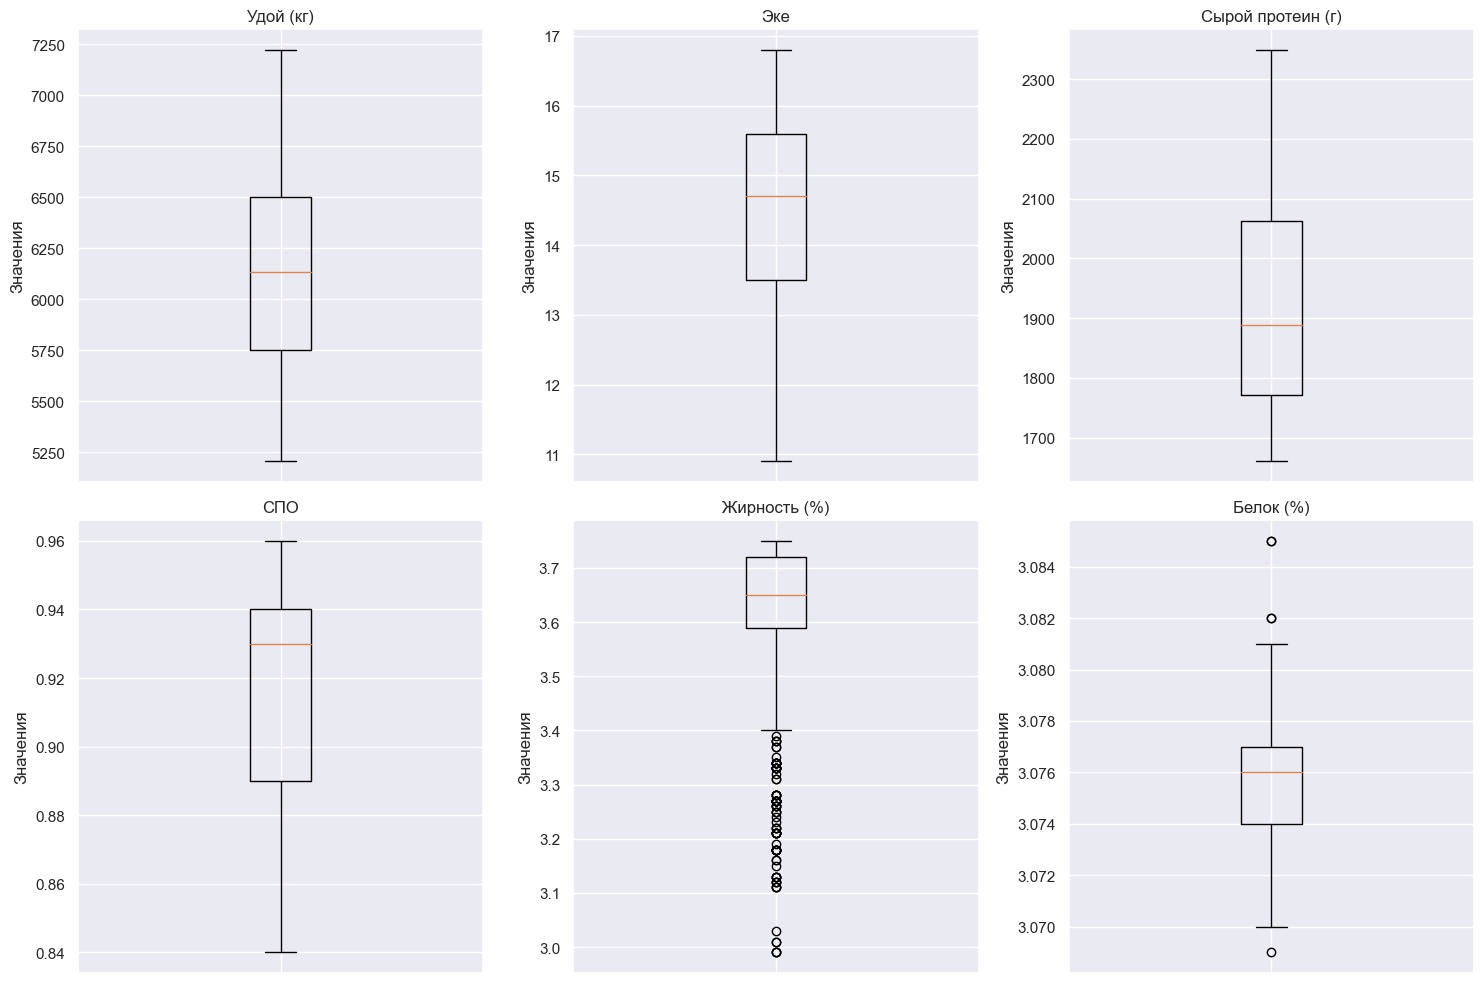

In [29]:
# построим графики
data = [
    ferma_main['удой_кг'],
    ferma_main['эке'],
    ferma_main['сырой_протеин_г'],
    ferma_main['спо'],
    ferma_main['жирность_%'],
    ferma_main['белок_%']
]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten()

labels = ['Удой (кг)', 'Эке', 'Сырой протеин (г)', 'СПО', 'Жирность (%)', 'Белок (%)']
for i, ax in enumerate(axs):
    ax.boxplot(data[i])
    ax.set_title(labels[i])
    ax.set_ylabel('Значения')
    ax.set_xticklabels([''])

plt.tight_layout()
plt.show()

тем не менее графики подсказывают, что выбросы в жирности и белке все же присутствуют, но они не столь критичны на данный момент. вернемся к этому вопросу в процессе обучения модели, будет ли это сильно влиять или нет

In [30]:
# что не так с жирностью
ferma_main['жирность_%'].sort_values().unique()

array([2.99, 3.01, 3.03, 3.11, 3.12, 3.13, 3.15, 3.16, 3.18, 3.19, 3.21,
       3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.31, 3.32, 3.33, 3.34,
       3.35, 3.37, 3.38, 3.39, 3.4 , 3.41, 3.42, 3.44, 3.48, 3.49, 3.53,
       3.54, 3.55, 3.57, 3.58, 3.59, 3.61, 3.62, 3.63, 3.64, 3.65, 3.69,
       3.7 , 3.71, 3.72, 3.73, 3.74, 3.75])

In [31]:
# что не так с белками
ferma_main['белок_%'].sort_values().unique()

array([3.069, 3.07 , 3.071, 3.072, 3.073, 3.074, 3.075, 3.076, 3.077,
       3.078, 3.079, 3.08 , 3.081, 3.082, 3.085])

в принципе не вижу ничего страшного в этих данных

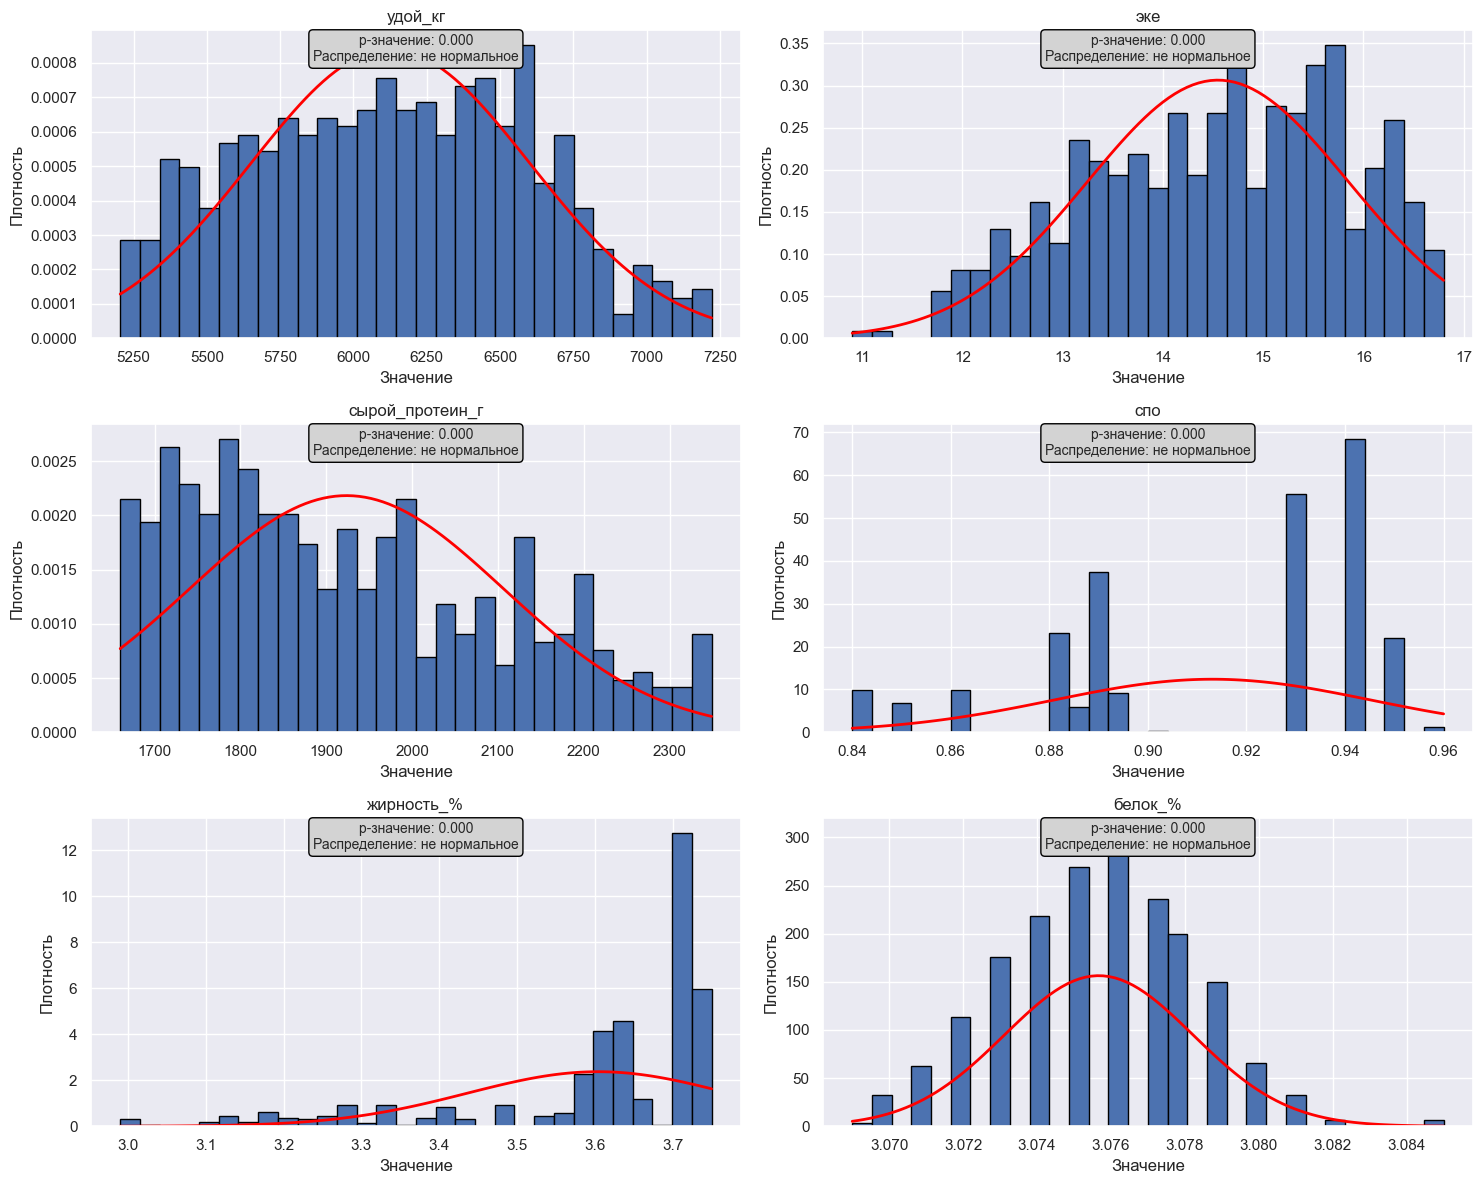

In [32]:
# проверим распределение данных
check_normal_quant_features(ferma_main, drop=['id'])

Если верить тесту - то у нас нет нормальных распределений в количественных данных, хотя к тесту на счет белка есть вопросы - выглядит визуально как нормальное распределение.

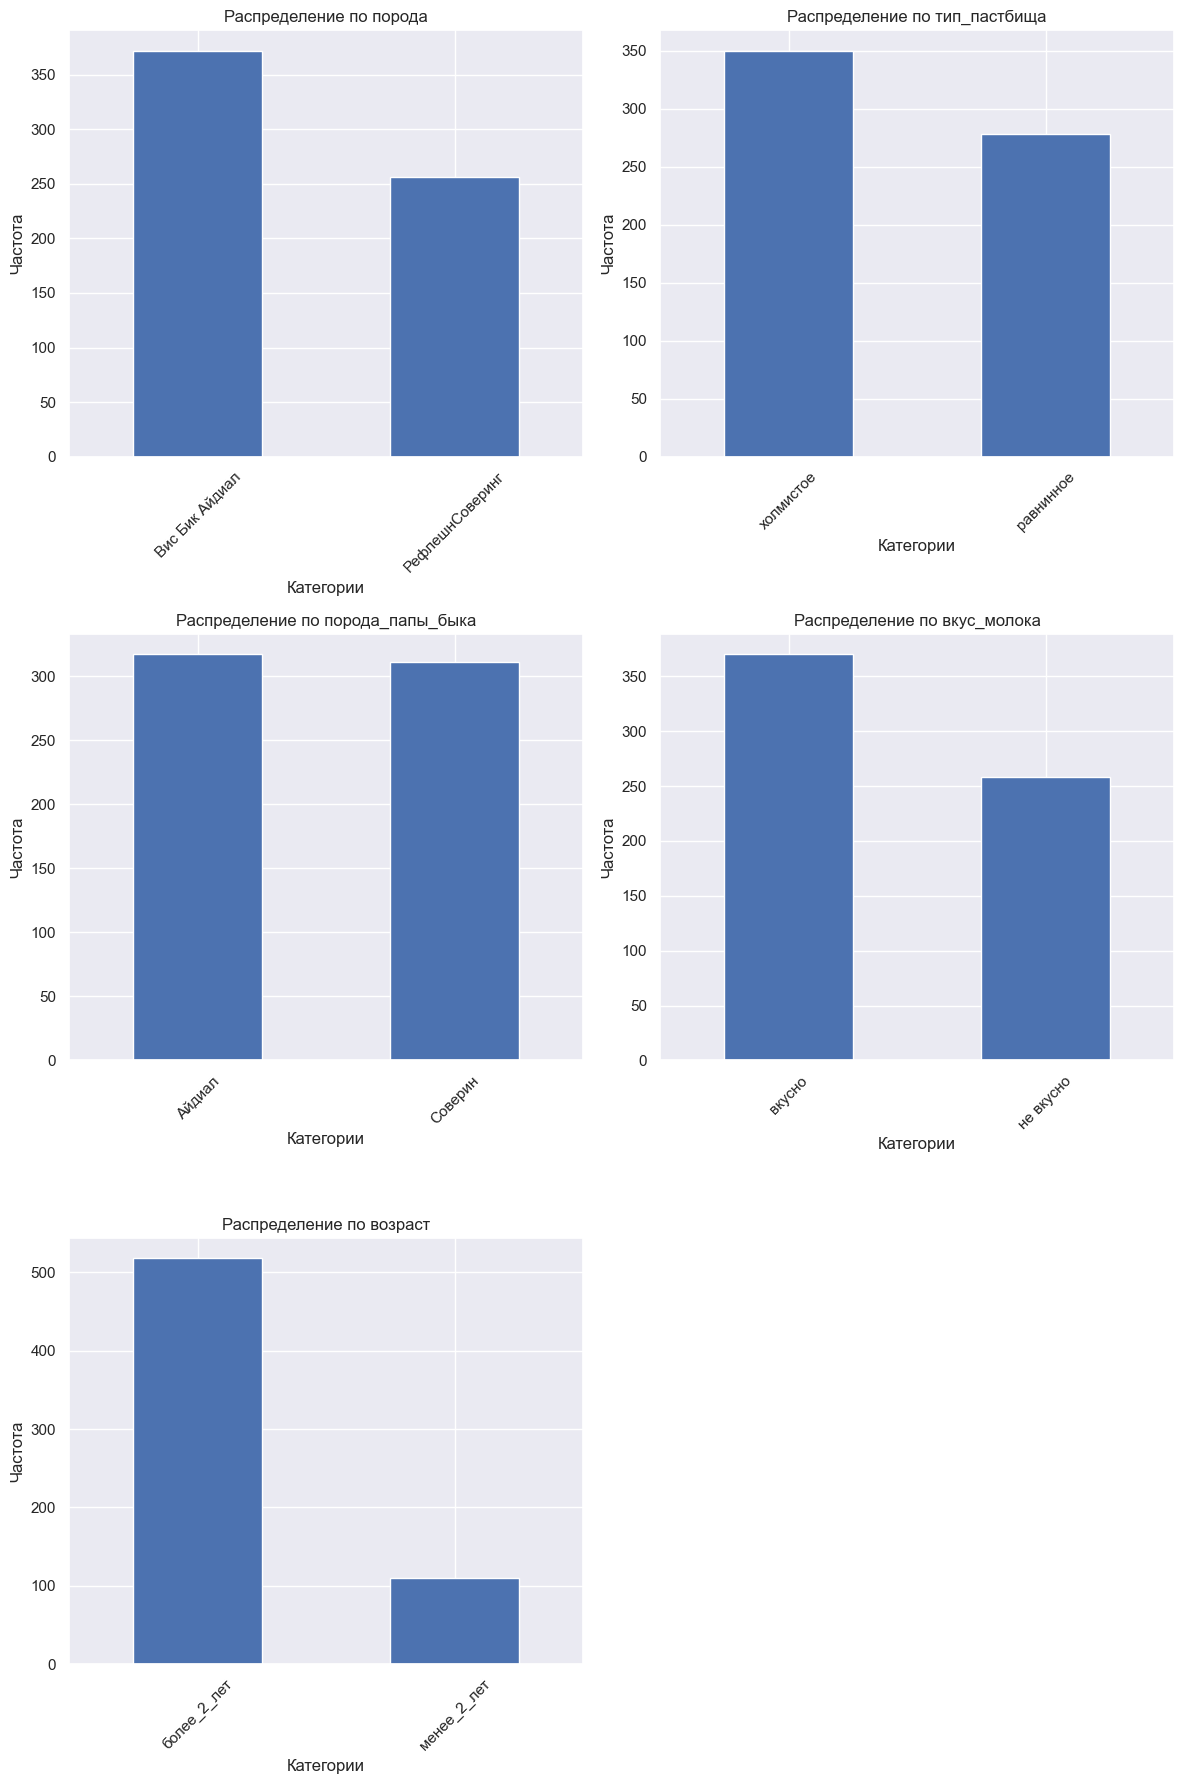

In [33]:
check_categorical_features(ferma_main)

Теперь мы знаем чуточку больше о коровах нашего фермера

## Изучим детальнее ferma_dad

In [34]:
display(ferma_dad.info())
display(ferma_dad.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

count   mean    std  min    25%    50%    75%    max
id 629.00 315.00 181.72 1.00 158.00 315.00 472.00 629.00

In [35]:
ferma_dad['имя_папы'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

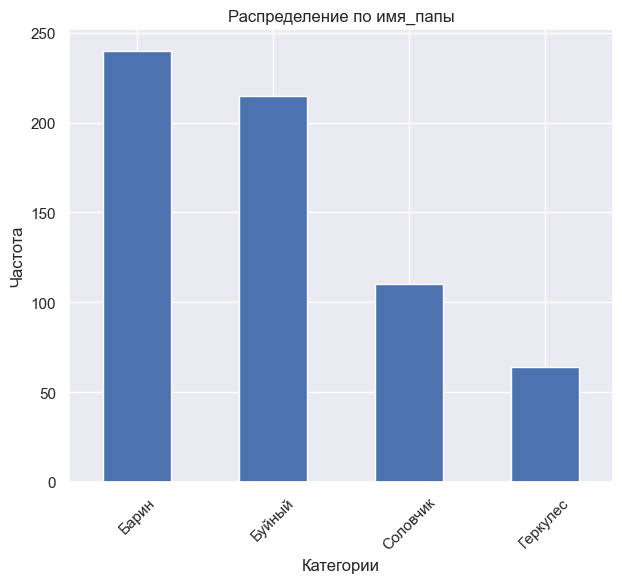

In [36]:
check_categorical_features(ferma_dad)

быков осеменителей не так уж и много - всего 4

## Изучим детальнее cow_buy

In [37]:
display(cow_buy.info())
display(cow_buy.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   порода            20 non-null     object 
 1   тип_пастбища      20 non-null     object 
 2   порода_папы_быка  20 non-null     object 
 3   имя_папы          20 non-null     object 
 4   жирность_%        20 non-null     float64
 5   белок_%           20 non-null     float64
 6   возраст           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

count  mean  std  min  25%  50%  75%  max
жирность_%  20.00  3.58 0.13 3.34 3.51 3.59 3.65 3.77
белок_%     20.00  3.07 0.01 3.05 3.06 3.07 3.08 3.08

на покупку у нас всего 20 коров и показатели по ним в принципе выглядят неплохо

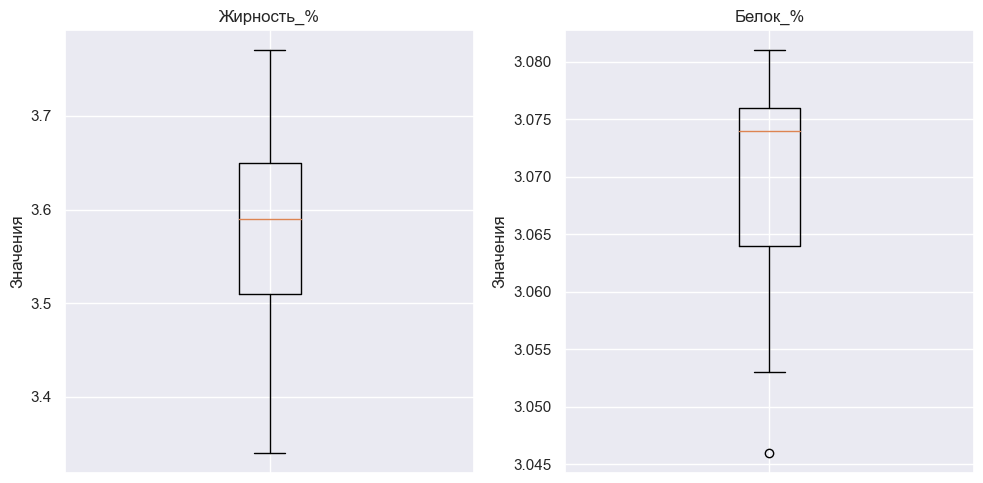

In [38]:
data = [
    cow_buy['жирность_%'],
    cow_buy['белок_%']
]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs = axs.flatten()

labels = ['Жирность_%', 'Белок_%']
for i, ax in enumerate(axs):
    ax.boxplot(data[i])
    ax.set_title(labels[i])
    ax.set_ylabel('Значения')
    ax.set_xticklabels([''])

plt.tight_layout()
plt.show()

Есть небольшой выброс, но все в рамках нормы

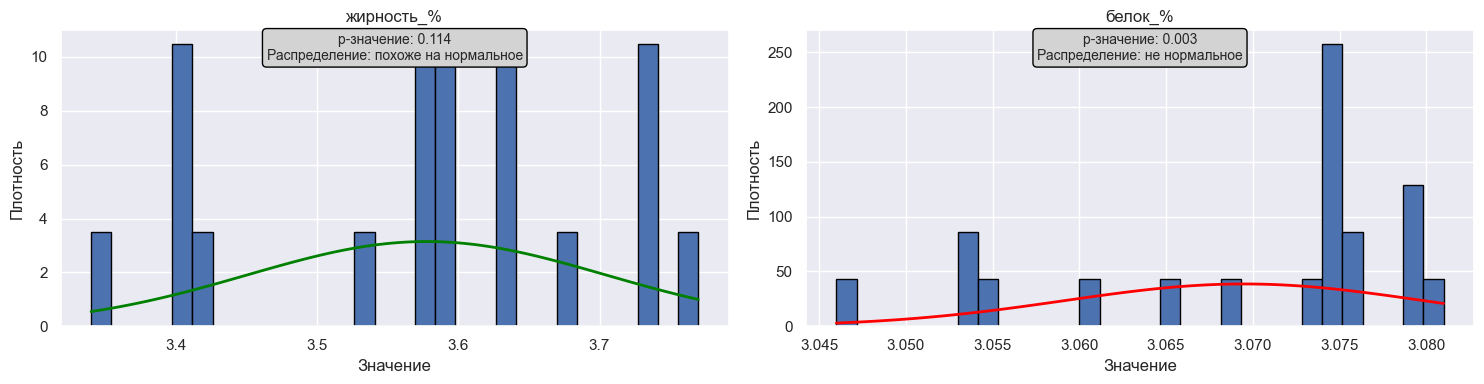

In [39]:
check_normal_quant_features(cow_buy)

а тут распределение 50/50 получилось

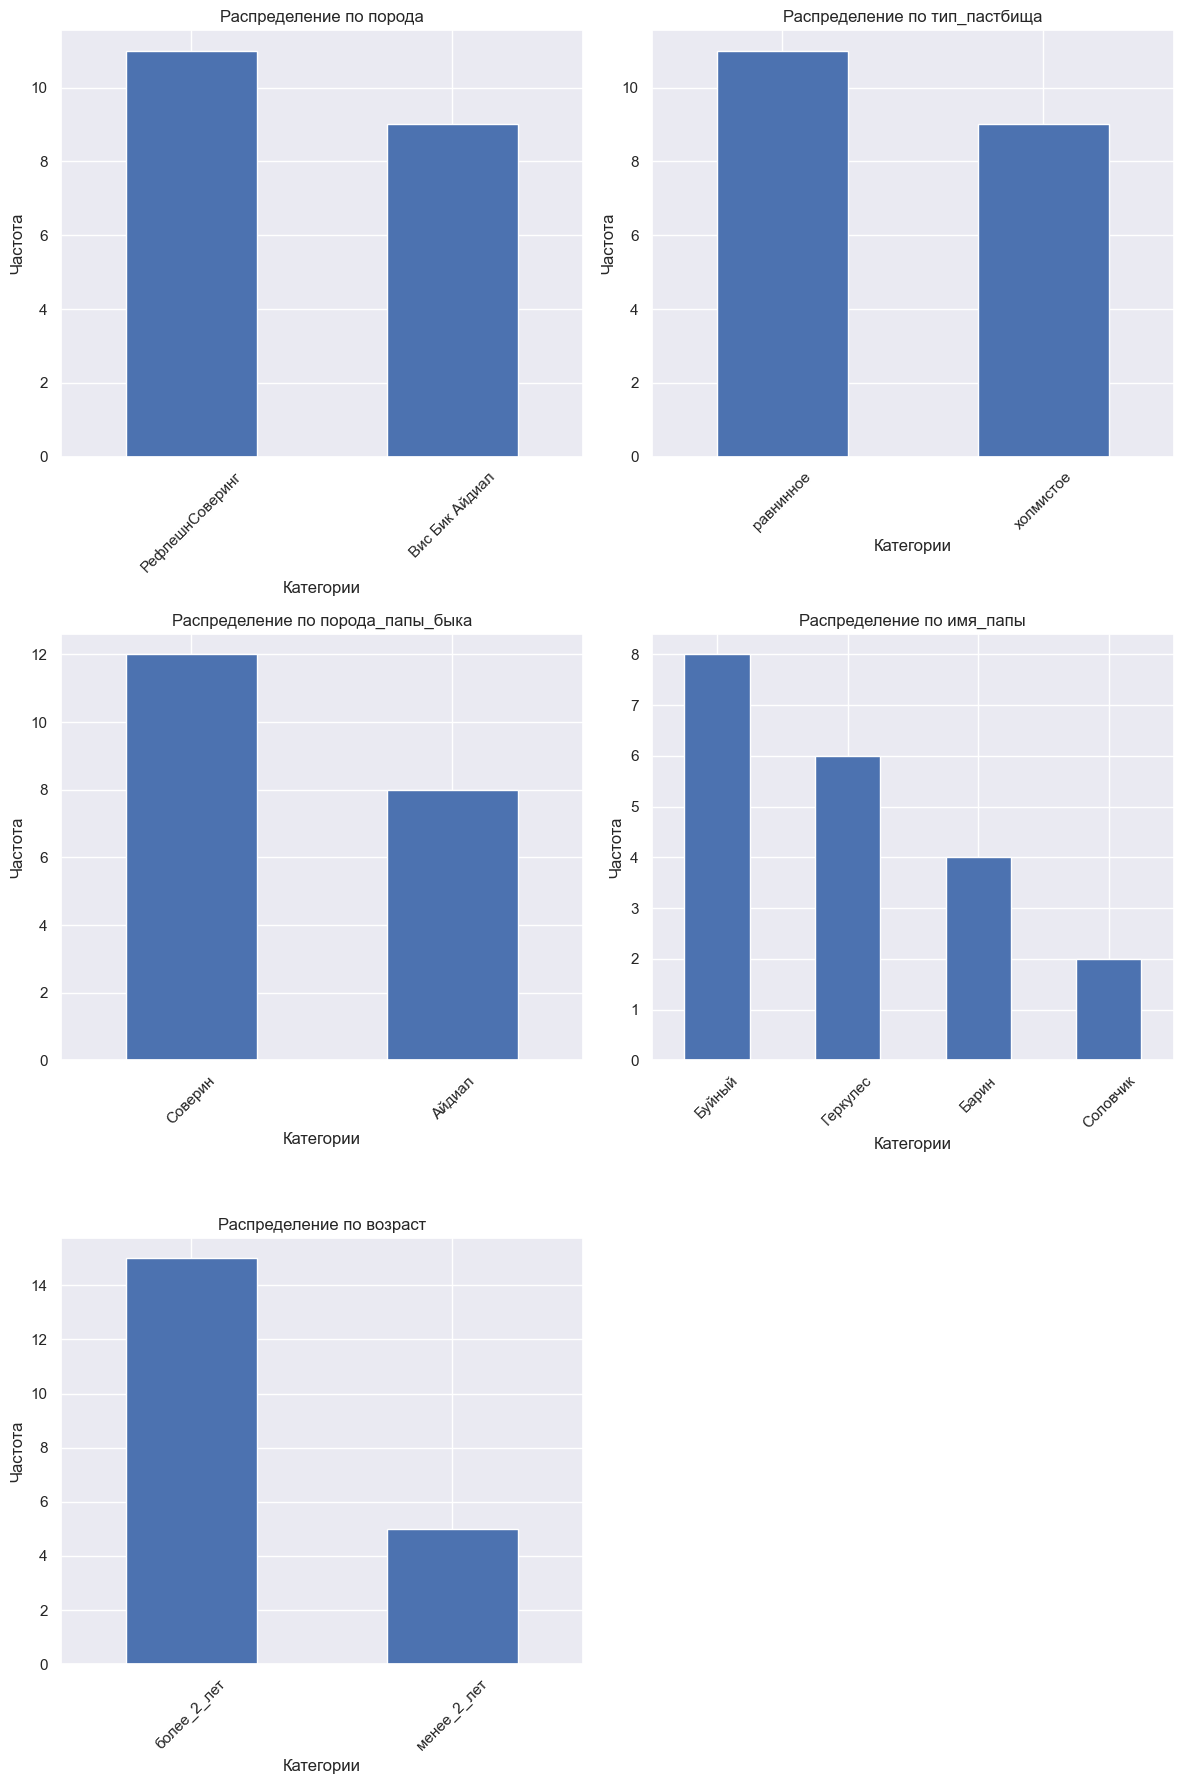

In [40]:
check_categorical_features(cow_buy)

И о коровах на продажу узнали немного больше

Вопрос: расскажите, как вы планируете улучшить данные  

Если вопрос глобальный - то фермеру надо внимательнее следить за тем, как он заполняет свои данные. К счастью, 1 ошибка на 600+ позиций не так страшно  
Если вопрос в рамках задачи - неадекватный удой мы уже удалили, а выбросы по жирности и белку коров выглядят нормально

## Выводы

Провели оценку исходных данных, нашли и исправили ряд проблем:  
1) ошибочный удой;  
2) неявные дубликаты среди пастбищь, имен и пород.

# Корреляционный анализ признаков в датасете ferma_main.csv

## Изучите взаимосвязь между признаками: рассчитайте коэффициенты корреляции между всеми признаками.

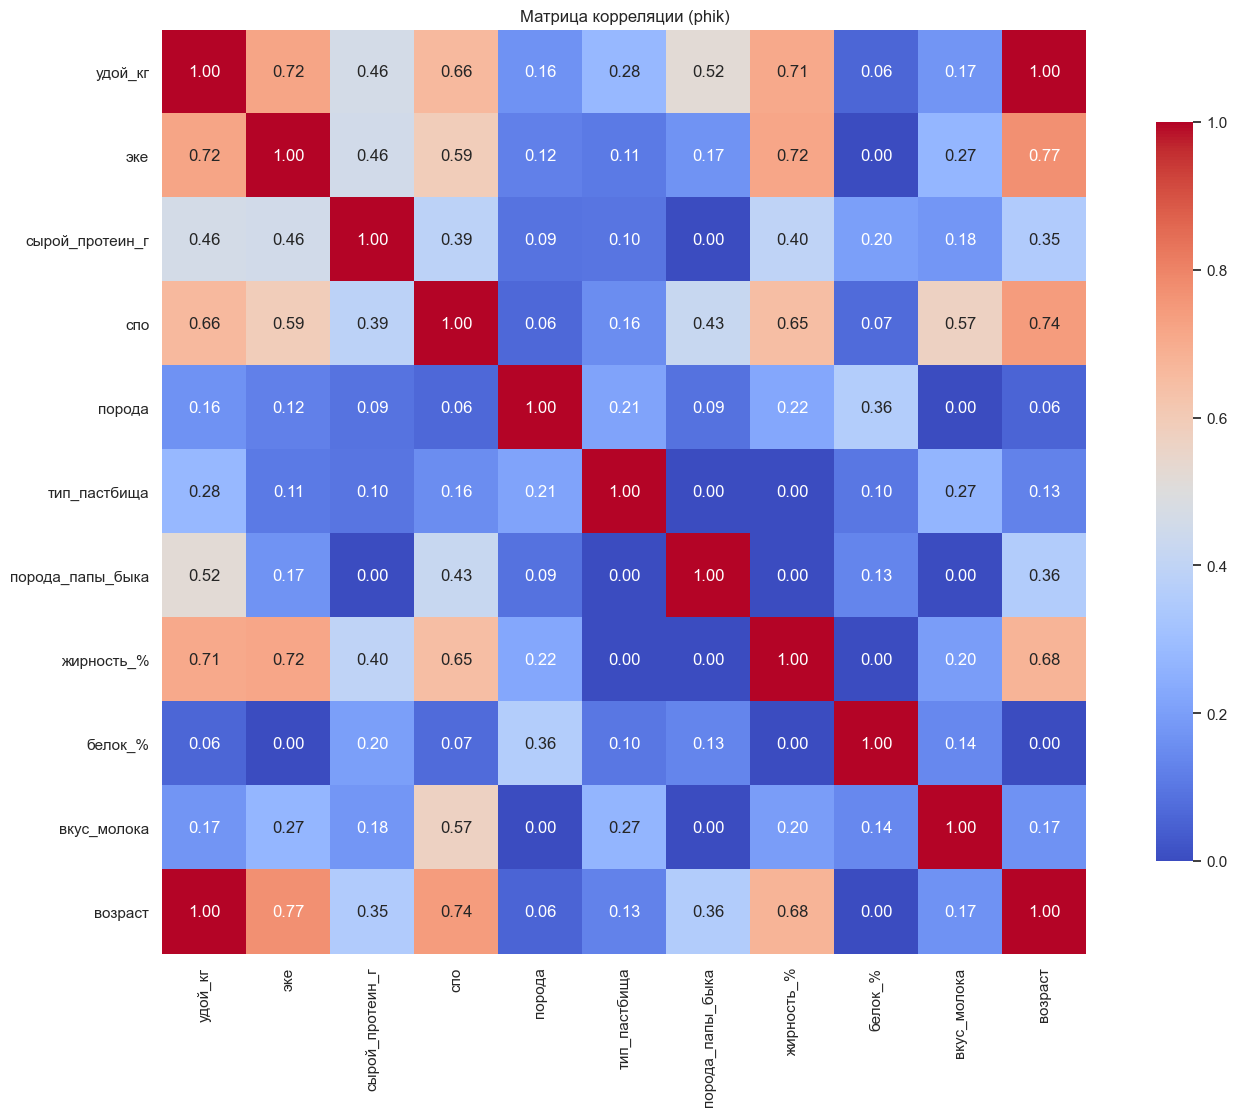

In [41]:
# оценим корреляцию, в том числе и с учетом категориальных признаков
# можно закодировать, но мы попробуем phik

# исключаем столбец 'id'
ferma_cor = ferma_main.drop(columns=['id'])

# вычисляем матрицу корреляции с использованием phik
correlation_matrix = ferma_cor.phik_matrix(interval_cols=['удой_кг','эке','сырой_протеин_г','спо','жирность_%', 'белок_%'])

# визуализируем
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляции (phik)')
plt.show()

In [42]:
# выведем корреляцию с 'удой_кг' и 'вкус_молока'
udoy_corr = correlation_matrix['удой_кг'].sort_values(ascending=False)
vkus_corr = correlation_matrix['вкус_молока'].sort_values(ascending=False)

display("Сильня корреляция с удой_кг:")
display(udoy_corr[udoy_corr > 0.5])

display("Слабая корреляция с удой_кг:")
display(udoy_corr[udoy_corr < 0.5])

display("Сильная корреляция с вкус_молока:")
display(vkus_corr[vkus_corr > 0.5])

display("Слабая корреляция с вкус_молока:")
display(vkus_corr[vkus_corr < 0.5])

'Сильня корреляция с удой_кг:'

удой_кг            1.00
возраст            1.00
эке                0.72
жирность_%         0.71
спо                0.66
порода_папы_быка   0.52
Name: удой_кг, dtype: float64

'Слабая корреляция с удой_кг:'

сырой_протеин_г   0.46
тип_пастбища      0.28
вкус_молока       0.17
порода            0.16
белок_%           0.06
Name: удой_кг, dtype: float64

'Сильная корреляция с вкус_молока:'

вкус_молока   1.00
спо           0.57
Name: вкус_молока, dtype: float64

'Слабая корреляция с вкус_молока:'

эке                0.27
тип_пастбища       0.27
жирность_%         0.20
сырой_протеин_г    0.18
удой_кг            0.17
возраст            0.17
белок_%            0.14
порода             0.00
порода_папы_быка   0.00
Name: вкус_молока, dtype: float64

In [43]:
# проверим зависимость VIF
# исключаем зависимые переменные
X_test = ferma_main.drop(columns=['удой_кг', 'вкус_молока'])

# преобразуем категориальные признаки в числовые
X_test = pd.get_dummies(X_test, drop_first=True)

# добавляем константу
X_test = X_test.assign(const=1)

# вычисляем VIF
vif_data = pd.DataFrame()
vif_data["Признаки"] = X_test.columns
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i) for i in range(X_test.shape[1])]

# удаляем константу из результатов
vif_data = vif_data[vif_data["Признаки"] != "const"]

# выводим результаты
display(vif_data)

Признаки  VIF
0                        id 1.11
1                       эке 2.72
2           сырой_протеин_г 1.36
3                       спо 2.88
4                жирность_% 2.01
5                   белок_% 1.22
6    порода_РефлешнСоверинг 1.23
7    тип_пастбища_холмистое 1.08
8  порода_папы_быка_Соверин 1.16
9       возраст_менее_2_лет 1.67

Из матрицы видно следующее:  
1) на удой влияет - качество корма (эке, спо), возраст (те кому больше 2 лет) и имя папы быка;  
2) на вкус молока - СПО (Сахаро-протеиновое соотношение);  
3) порода коровы, порода папы, место выпаса - практически не влияют на таргеты;  
4) мультиколлинеарность среди признаков не прослеживается    
5) тоже самое и с качеством молока, можно сделать признак качество_молока объединив вкус молока, содержание белка и жирность

## Постройте диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков.

In [44]:
display(ferma_main.sample(2))

id  удой_кг   эке  сырой_протеин_г  спо          порода тип_пастбища  \
465  467     5722 15.00             1716 0.89  Вис Бик Айдиал    холмистое   
366  368     5733 13.50             1986 0.89  Вис Бик Айдиал    равнинное   

    порода_папы_быка  жирность_%  белок_% вкус_молока      возраст  
465          Соверин        3.61     3.08      вкусно  более_2_лет  
366          Соверин        3.65     3.08   не вкусно  более_2_лет

### Порода

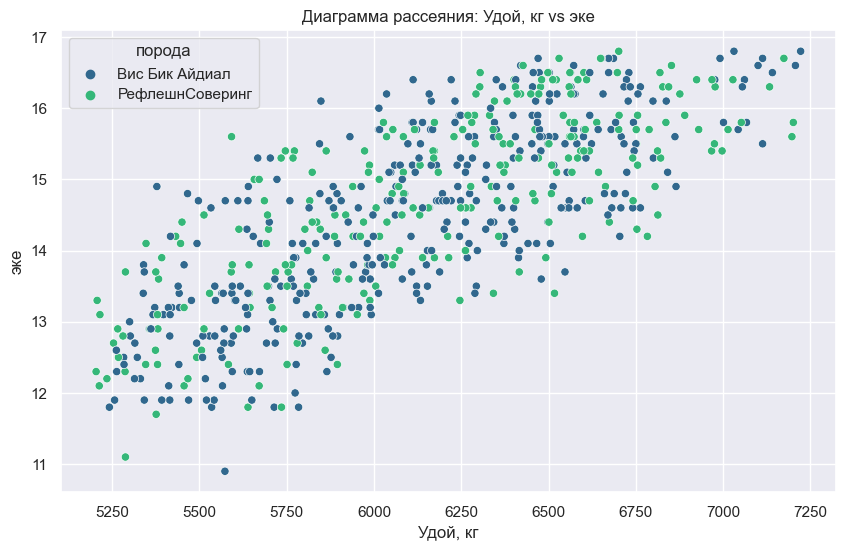

'Существует положительная корреляция (высокая) между удоем и эке для категории Вис Бик Айдиал (коэффициент: 0.77).'

'Существует положительная корреляция (высокая) между удоем и эке для категории РефлешнСоверинг (коэффициент: 0.76).'

'Тип зависимости между удоем и эке: нелинейная (стандартное отклонение остатков: 0.84, стандартное отклонение эке: 1.30, стандартное отклонение остатков больше 10% (64.39%) от стандартного отклонения эке).'

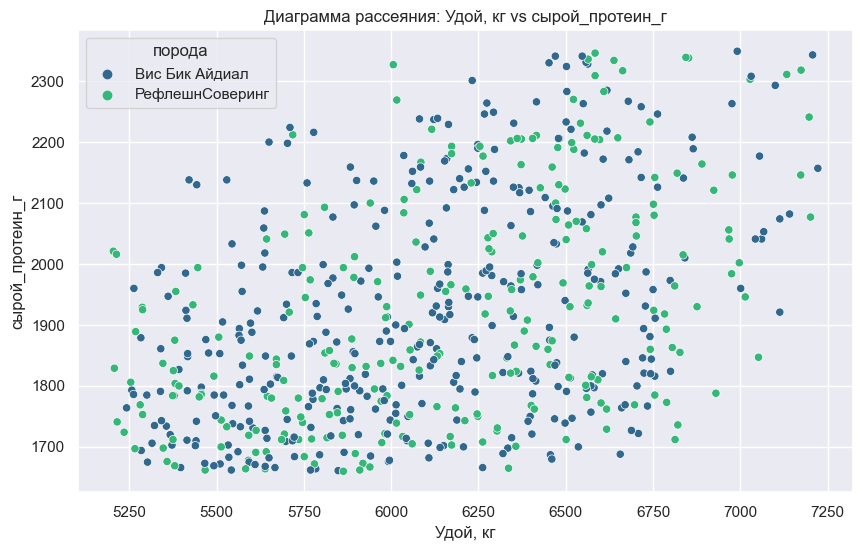

'Существует положительная корреляция (средняя) между удоем и сырой_протеин_г для категории Вис Бик Айдиал (коэффициент: 0.42).'

'Существует положительная корреляция (средняя) между удоем и сырой_протеин_г для категории РефлешнСоверинг (коэффициент: 0.48).'

'Тип зависимости между удоем и сырой_протеин_г: нелинейная (стандартное отклонение остатков: 163.44, стандартное отклонение сырой_протеин_г: 182.69, стандартное отклонение остатков больше 10% (89.47%) от стандартного отклонения сырой_протеин_г).'

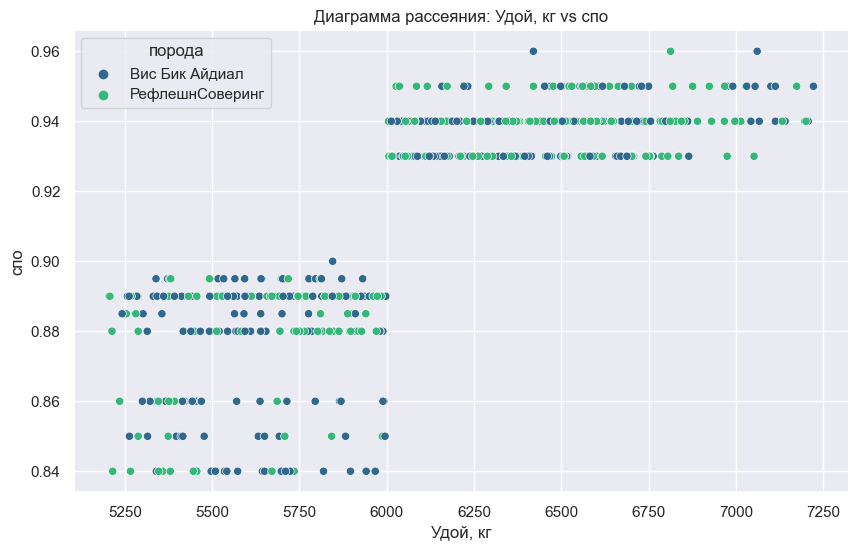

'Существует положительная корреляция (высокая) между удоем и спо для категории Вис Бик Айдиал (коэффициент: 0.80).'

'Существует положительная корреляция (высокая) между удоем и спо для категории РефлешнСоверинг (коэффициент: 0.82).'

'Тип зависимости между удоем и спо: нелинейная (стандартное отклонение остатков: 0.02, стандартное отклонение спо: 0.03, стандартное отклонение остатков больше 10% (59.15%) от стандартного отклонения спо).'

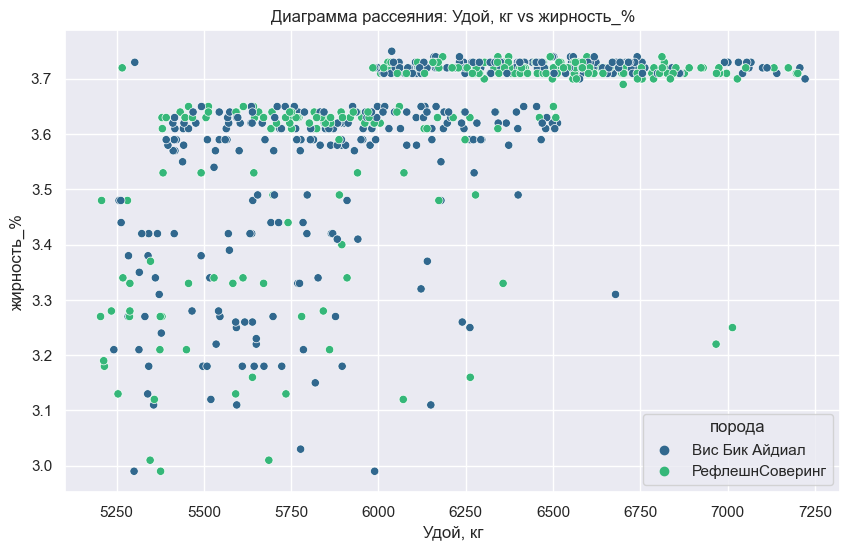

'Существует положительная корреляция (средняя) между удоем и жирность_% для категории Вис Бик Айдиал (коэффициент: 0.61).'

'Существует положительная корреляция (средняя) между удоем и жирность_% для категории РефлешнСоверинг (коэффициент: 0.58).'

'Тип зависимости между удоем и жирность_%: нелинейная (стандартное отклонение остатков: 0.13, стандартное отклонение жирность_%: 0.17, стандартное отклонение остатков больше 10% (79.93%) от стандартного отклонения жирность_%).'

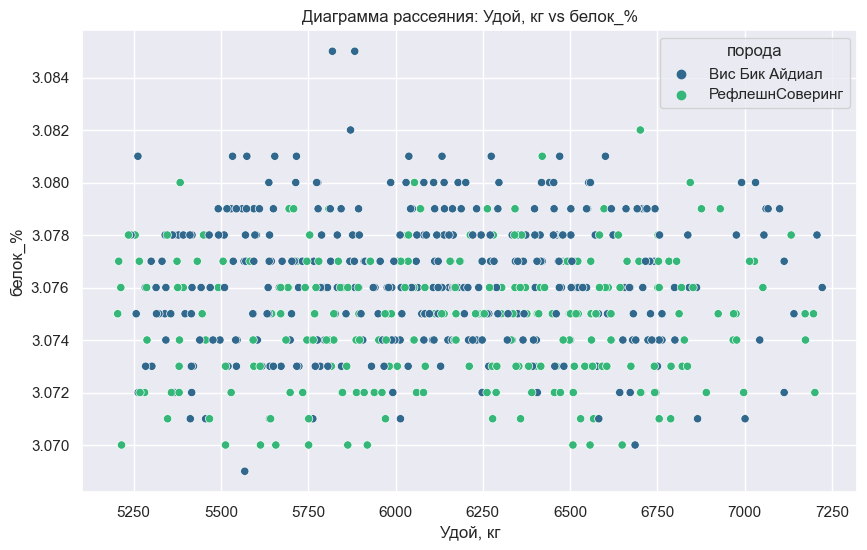

'Существует положительная корреляция (низкая) между удоем и белок_% для категории Вис Бик Айдиал (коэффициент: 0.02).'

'Существует положительная корреляция (низкая) между удоем и белок_% для категории РефлешнСоверинг (коэффициент: 0.03).'

'Тип зависимости между удоем и белок_%: нелинейная (стандартное отклонение остатков: 0.00, стандартное отклонение белок_%: 0.00, стандартное отклонение остатков больше 10% (100.00%) от стандартного отклонения белок_%).'

'Средние значения по категориям:'

порода  удой_кг   эке  сырой_протеин_г  спо  жирность_%  белок_%
0   Вис Бик Айдиал  6112.00 14.60          1885.50 0.93        3.60     3.08
1  РефлешнСоверинг  6178.50 14.90          1889.50 0.93        3.61     3.07

'Наиболее выгодная категория по удою: РефлешнСоверинг с удоем 6178.50 кг.'

In [45]:
# выбираем категориальный признак, по которому будем строить диаграммы рассеяния
categorical_col = 'порода'
get_scatterplot(categorical_col)

Выводы:  
Повышение качества корма в равной мере влияет на обе породы  
Тем не менее - более выгодная порода РефлешнСоверинг

### Тип пастбища

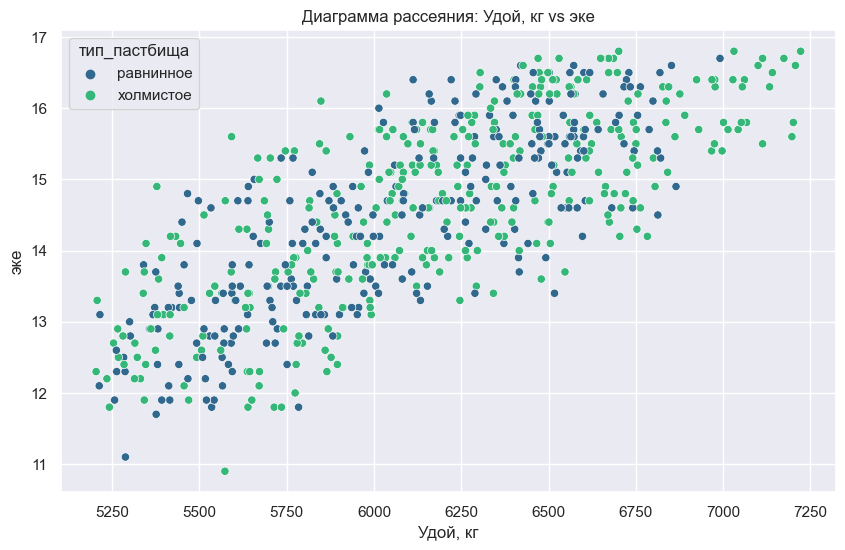

'Существует положительная корреляция (высокая) между удоем и эке для категории равнинное (коэффициент: 0.79).'

'Существует положительная корреляция (средняя) между удоем и эке для категории холмистое (коэффициент: 0.75).'

'Тип зависимости между удоем и эке: нелинейная (стандартное отклонение остатков: 0.84, стандартное отклонение эке: 1.30, стандартное отклонение остатков больше 10% (64.39%) от стандартного отклонения эке).'

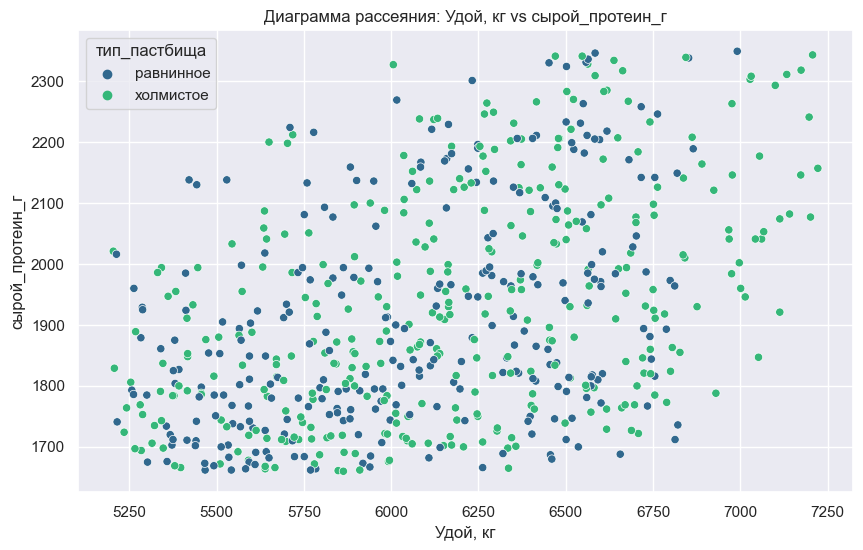

'Существует положительная корреляция (средняя) между удоем и сырой_протеин_г для категории равнинное (коэффициент: 0.41).'

'Существует положительная корреляция (средняя) между удоем и сырой_протеин_г для категории холмистое (коэффициент: 0.46).'

'Тип зависимости между удоем и сырой_протеин_г: нелинейная (стандартное отклонение остатков: 163.44, стандартное отклонение сырой_протеин_г: 182.69, стандартное отклонение остатков больше 10% (89.47%) от стандартного отклонения сырой_протеин_г).'

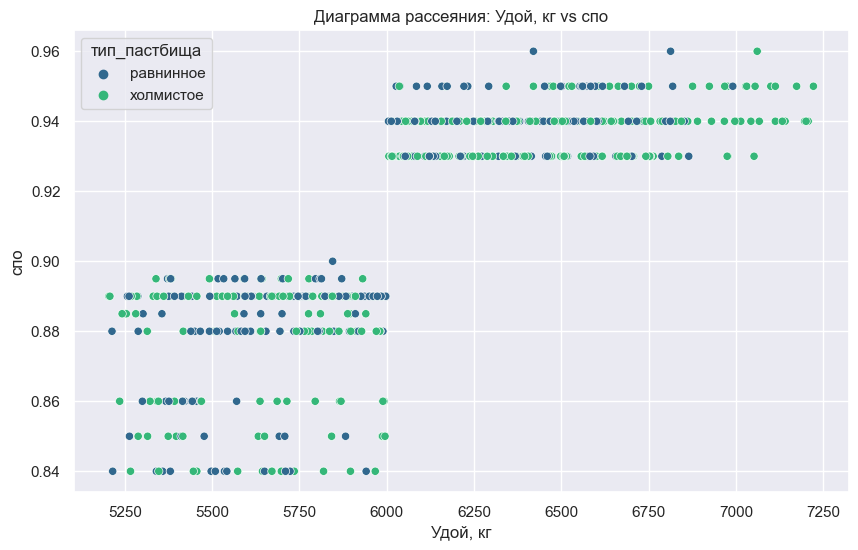

'Существует положительная корреляция (высокая) между удоем и спо для категории равнинное (коэффициент: 0.84).'

'Существует положительная корреляция (высокая) между удоем и спо для категории холмистое (коэффициент: 0.78).'

'Тип зависимости между удоем и спо: нелинейная (стандартное отклонение остатков: 0.02, стандартное отклонение спо: 0.03, стандартное отклонение остатков больше 10% (59.15%) от стандартного отклонения спо).'

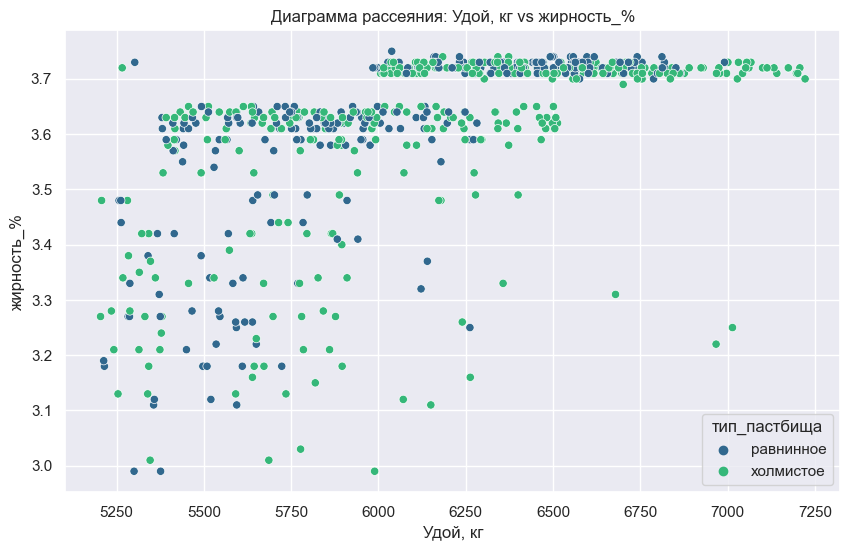

'Существует положительная корреляция (средняя) между удоем и жирность_% для категории равнинное (коэффициент: 0.69).'

'Существует положительная корреляция (средняя) между удоем и жирность_% для категории холмистое (коэффициент: 0.56).'

'Тип зависимости между удоем и жирность_%: нелинейная (стандартное отклонение остатков: 0.13, стандартное отклонение жирность_%: 0.17, стандартное отклонение остатков больше 10% (79.93%) от стандартного отклонения жирность_%).'

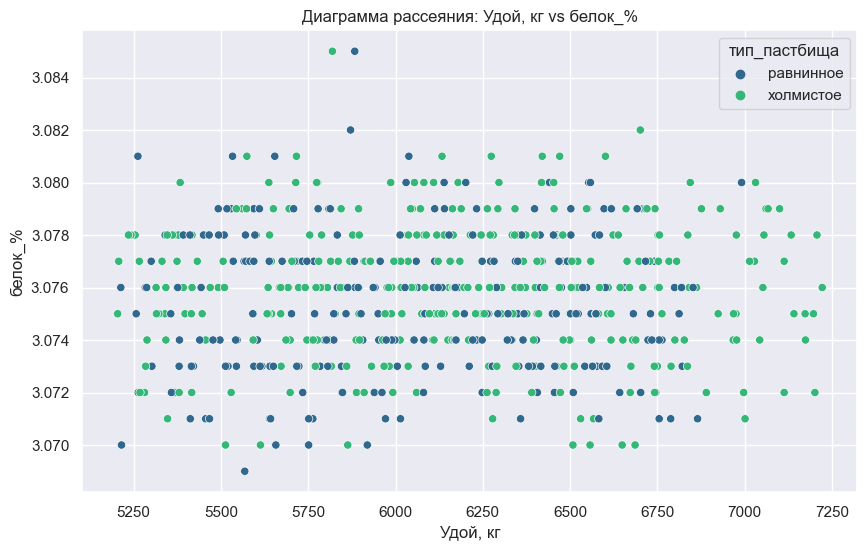

'Существует положительная корреляция (низкая) между удоем и белок_% для категории равнинное (коэффициент: 0.01).'

'Существует отрицательная корреляция (низкая) между удоем и белок_% для категории холмистое (коэффициент: -0.03).'

'Тип зависимости между удоем и белок_%: нелинейная (стандартное отклонение остатков: 0.00, стандартное отклонение белок_%: 0.00, стандартное отклонение остатков больше 10% (100.00%) от стандартного отклонения белок_%).'

'Средние значения по категориям:'

тип_пастбища  удой_кг   эке  сырой_протеин_г  спо  жирность_%  белок_%
0    равнинное     6061 14.60             1866 0.93        3.61     3.08
1    холмистое     6171 14.80             1912 0.93        3.60     3.08

'Наиболее выгодная категория по удою: холмистое с удоем 6171.00 кг.'

In [46]:
categorical_col = 'тип_пастбища'
get_scatterplot(categorical_col)

Выводы:  
Повышение качества корма в равной мере влияет на место выпаса коров  
Тем не менее - более выгодное место выпаса холмистое

### Порода папы быка

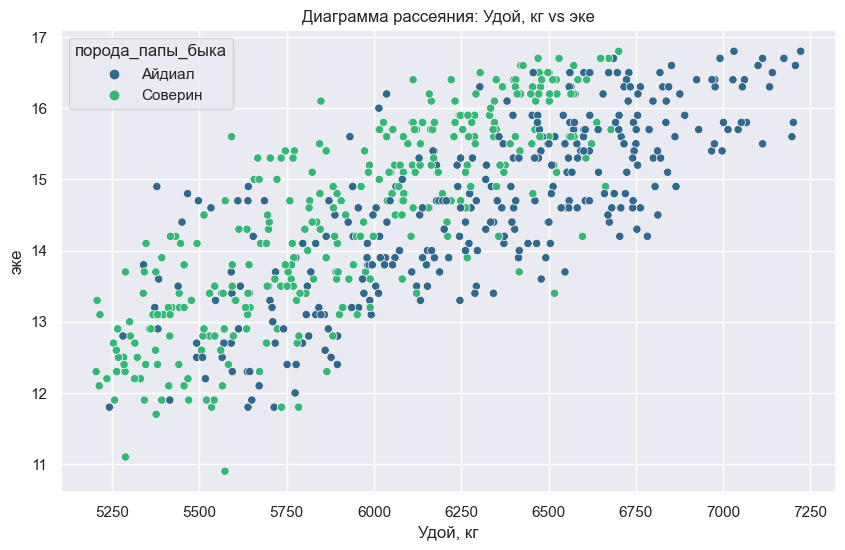

'Существует положительная корреляция (высокая) между удоем и эке для категории Айдиал (коэффициент: 0.78).'

'Существует положительная корреляция (высокая) между удоем и эке для категории Соверин (коэффициент: 0.82).'

'Тип зависимости между удоем и эке: нелинейная (стандартное отклонение остатков: 0.84, стандартное отклонение эке: 1.30, стандартное отклонение остатков больше 10% (64.39%) от стандартного отклонения эке).'

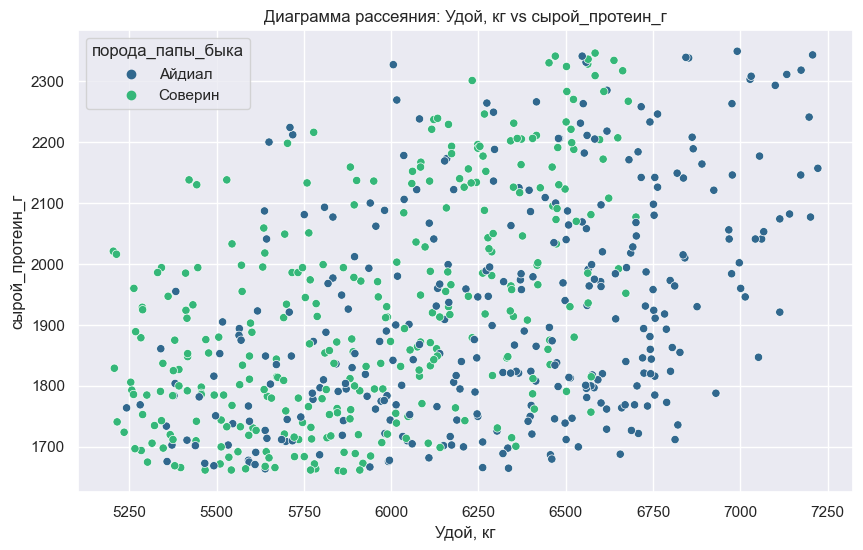

'Существует положительная корреляция (средняя) между удоем и сырой_протеин_г для категории Айдиал (коэффициент: 0.43).'

'Существует положительная корреляция (средняя) между удоем и сырой_протеин_г для категории Соверин (коэффициент: 0.55).'

'Тип зависимости между удоем и сырой_протеин_г: нелинейная (стандартное отклонение остатков: 163.44, стандартное отклонение сырой_протеин_г: 182.69, стандартное отклонение остатков больше 10% (89.47%) от стандартного отклонения сырой_протеин_г).'

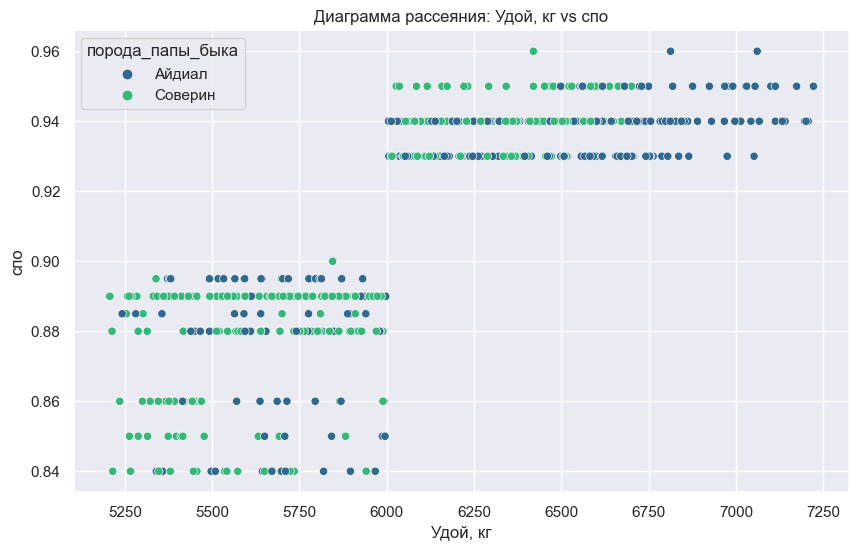

'Существует положительная корреляция (высокая) между удоем и спо для категории Айдиал (коэффициент: 0.78).'

'Существует положительная корреляция (высокая) между удоем и спо для категории Соверин (коэффициент: 0.84).'

'Тип зависимости между удоем и спо: нелинейная (стандартное отклонение остатков: 0.02, стандартное отклонение спо: 0.03, стандартное отклонение остатков больше 10% (59.15%) от стандартного отклонения спо).'

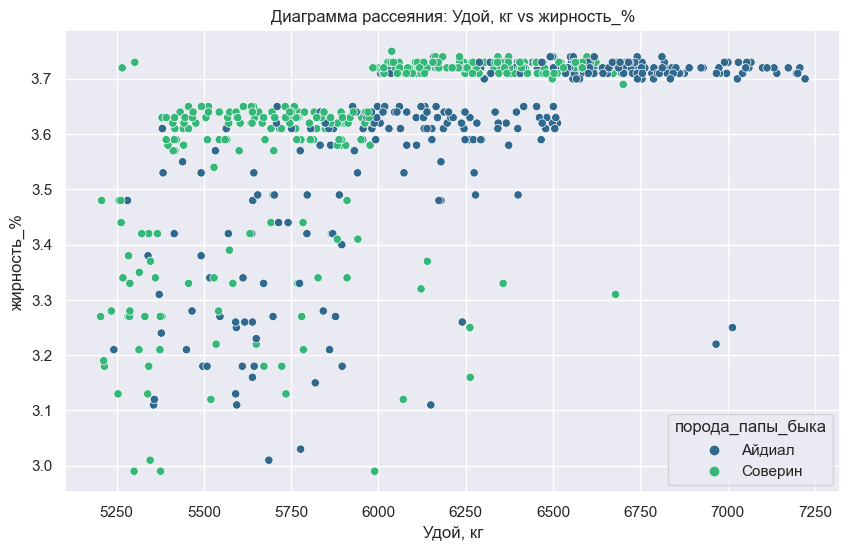

'Существует положительная корреляция (средняя) между удоем и жирность_% для категории Айдиал (коэффициент: 0.69).'

'Существует положительная корреляция (средняя) между удоем и жирность_% для категории Соверин (коэффициент: 0.59).'

'Тип зависимости между удоем и жирность_%: нелинейная (стандартное отклонение остатков: 0.13, стандартное отклонение жирность_%: 0.17, стандартное отклонение остатков больше 10% (79.93%) от стандартного отклонения жирность_%).'

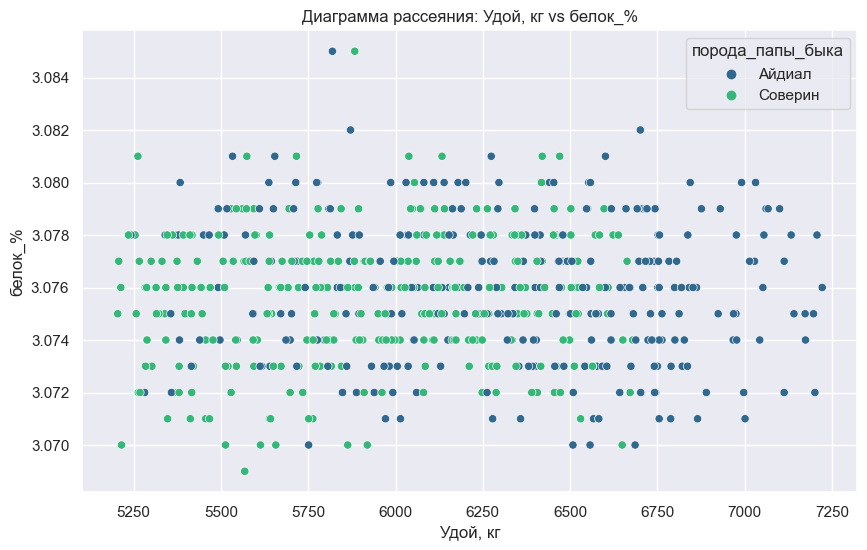

'Существует отрицательная корреляция (низкая) между удоем и белок_% для категории Айдиал (коэффициент: -0.10).'

'Существует положительная корреляция (низкая) между удоем и белок_% для категории Соверин (коэффициент: 0.08).'

'Тип зависимости между удоем и белок_%: нелинейная (стандартное отклонение остатков: 0.00, стандартное отклонение белок_%: 0.00, стандартное отклонение остатков больше 10% (100.00%) от стандартного отклонения белок_%).'

'Средние значения по категориям:'

порода_папы_быка  удой_кг   эке  сырой_протеин_г  спо  жирность_%  белок_%
0           Айдиал     6370 14.70             1890 0.93        3.61     3.08
1          Соверин     5919 14.60             1880 0.89        3.60     3.08

'Наиболее выгодная категория по удою: Айдиал с удоем 6370.00 кг.'

In [47]:
categorical_col = 'порода_папы_быка'
get_scatterplot(categorical_col)

Выводы:  
Повышение качества корма в большей мере влияет на породу Соверин папы быка  
Тем не менее - более выгодным будет порода Айдиал папы быка по удою

### Вкус молока

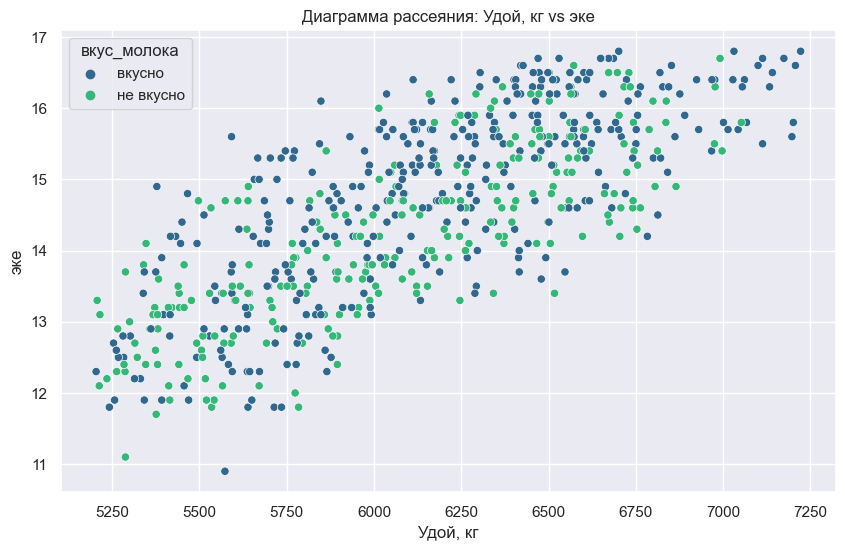

'Существует положительная корреляция (высокая) между удоем и эке для категории вкусно (коэффициент: 0.75).'

'Существует положительная корреляция (высокая) между удоем и эке для категории не вкусно (коэффициент: 0.78).'

'Тип зависимости между удоем и эке: нелинейная (стандартное отклонение остатков: 0.84, стандартное отклонение эке: 1.30, стандартное отклонение остатков больше 10% (64.39%) от стандартного отклонения эке).'

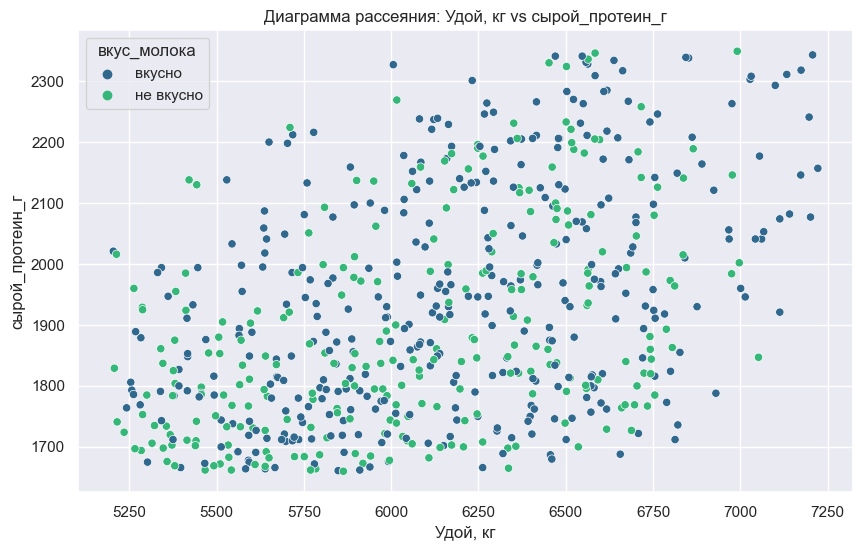

'Существует положительная корреляция (средняя) между удоем и сырой_протеин_г для категории вкусно (коэффициент: 0.44).'

'Существует положительная корреляция (средняя) между удоем и сырой_протеин_г для категории не вкусно (коэффициент: 0.43).'

'Тип зависимости между удоем и сырой_протеин_г: нелинейная (стандартное отклонение остатков: 163.44, стандартное отклонение сырой_протеин_г: 182.69, стандартное отклонение остатков больше 10% (89.47%) от стандартного отклонения сырой_протеин_г).'

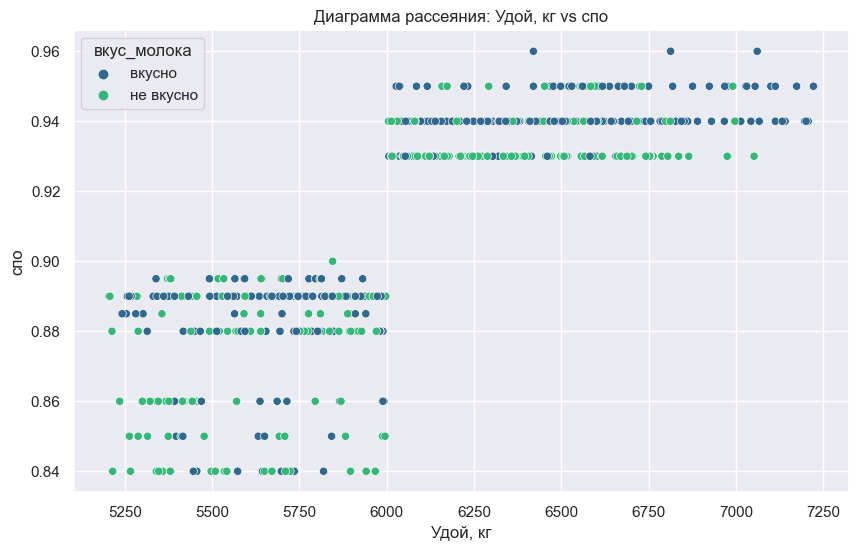

'Существует положительная корреляция (высокая) между удоем и спо для категории вкусно (коэффициент: 0.80).'

'Существует положительная корреляция (высокая) между удоем и спо для категории не вкусно (коэффициент: 0.81).'

'Тип зависимости между удоем и спо: нелинейная (стандартное отклонение остатков: 0.02, стандартное отклонение спо: 0.03, стандартное отклонение остатков больше 10% (59.15%) от стандартного отклонения спо).'

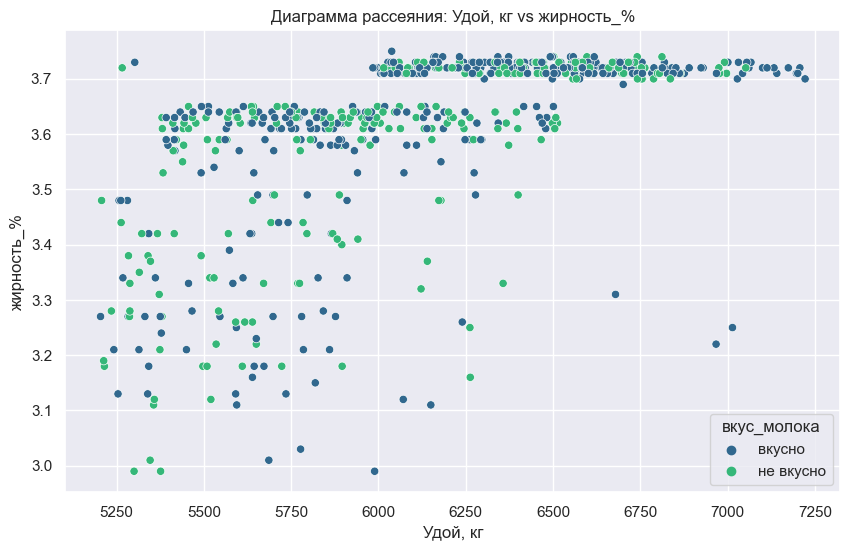

'Существует положительная корреляция (средняя) между удоем и жирность_% для категории вкусно (коэффициент: 0.56).'

'Существует положительная корреляция (средняя) между удоем и жирность_% для категории не вкусно (коэффициент: 0.65).'

'Тип зависимости между удоем и жирность_%: нелинейная (стандартное отклонение остатков: 0.13, стандартное отклонение жирность_%: 0.17, стандартное отклонение остатков больше 10% (79.93%) от стандартного отклонения жирность_%).'

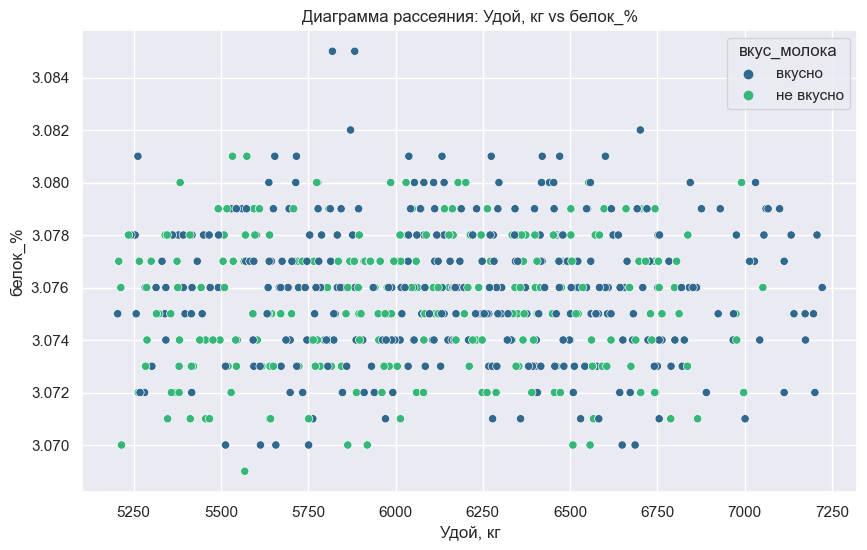

'Существует отрицательная корреляция (низкая) между удоем и белок_% для категории вкусно (коэффициент: -0.05).'

'Существует положительная корреляция (низкая) между удоем и белок_% для категории не вкусно (коэффициент: 0.04).'

'Тип зависимости между удоем и белок_%: нелинейная (стандартное отклонение остатков: 0.00, стандартное отклонение белок_%: 0.00, стандартное отклонение остатков больше 10% (100.00%) от стандартного отклонения белок_%).'

'Средние значения по категориям:'

вкус_молока  удой_кг   эке  сырой_протеин_г  спо  жирность_%  белок_%
0      вкусно  6166.00 15.00             1925 0.94        3.62     3.08
1   не вкусно  6061.50 14.20             1845 0.93        3.59     3.08

'Наиболее выгодная категория по удою: вкусно с удоем 6166.00 кг.'

In [48]:
categorical_col = 'вкус_молока'
get_scatterplot(categorical_col)

А вкусного молока не сильное то и больше, это точно надо исправлять

### Возраст

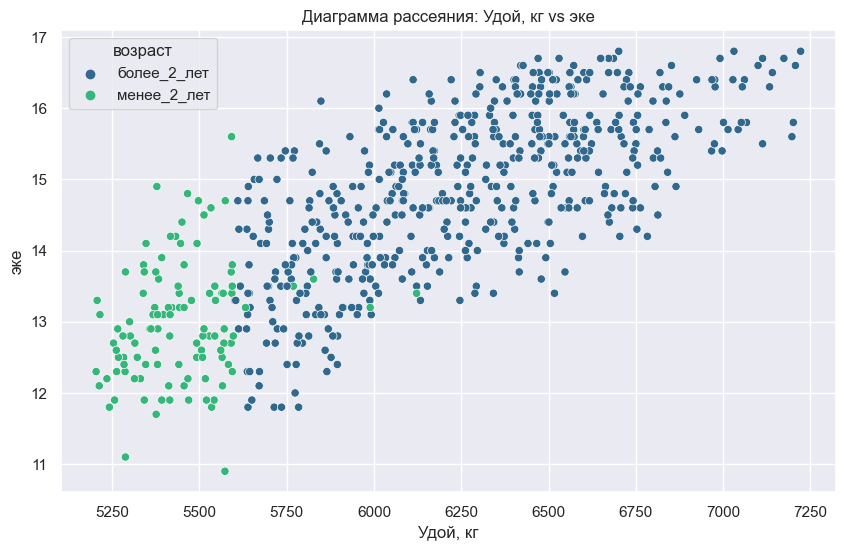

'Существует положительная корреляция (средняя) между удоем и эке для категории более_2_лет (коэффициент: 0.67).'

'Существует положительная корреляция (низкая) между удоем и эке для категории менее_2_лет (коэффициент: 0.22).'

'Тип зависимости между удоем и эке: нелинейная (стандартное отклонение остатков: 0.84, стандартное отклонение эке: 1.30, стандартное отклонение остатков больше 10% (64.39%) от стандартного отклонения эке).'

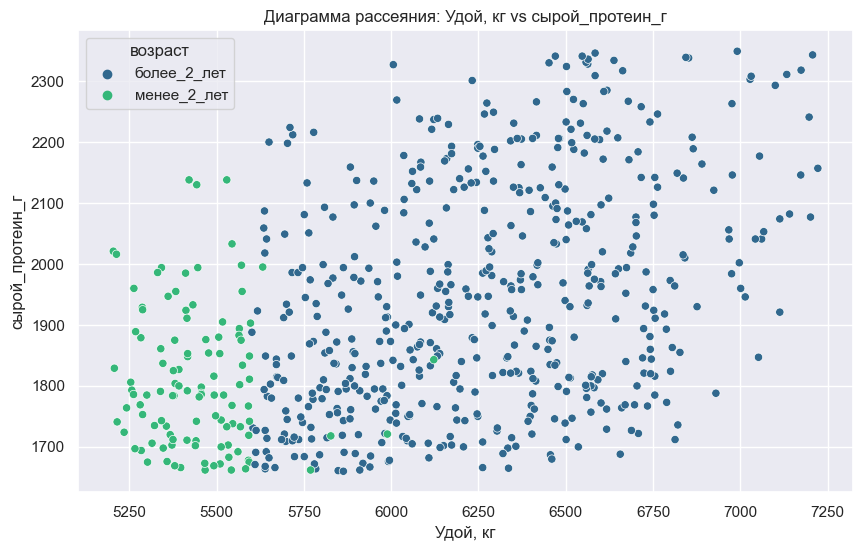

'Существует положительная корреляция (средняя) между удоем и сырой_протеин_г для категории более_2_лет (коэффициент: 0.38).'

'Существует отрицательная корреляция (низкая) между удоем и сырой_протеин_г для категории менее_2_лет (коэффициент: -0.09).'

'Тип зависимости между удоем и сырой_протеин_г: нелинейная (стандартное отклонение остатков: 163.44, стандартное отклонение сырой_протеин_г: 182.69, стандартное отклонение остатков больше 10% (89.47%) от стандартного отклонения сырой_протеин_г).'

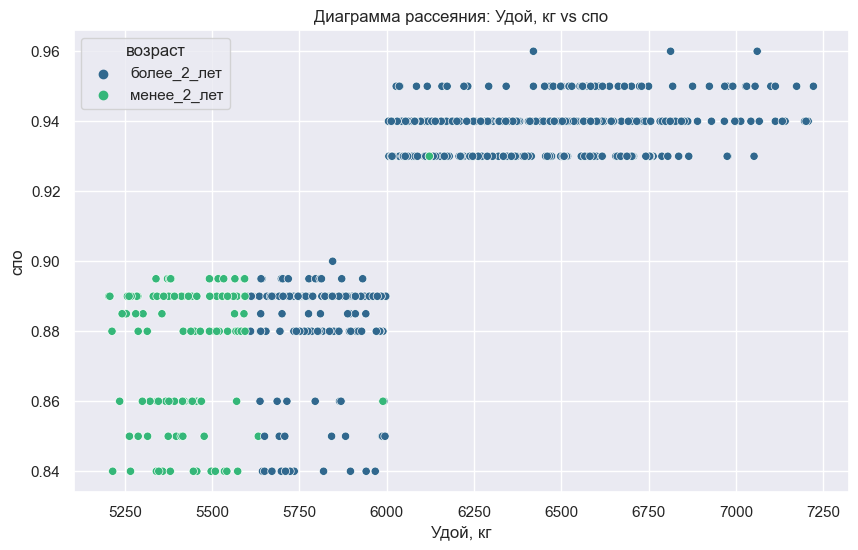

'Существует положительная корреляция (средняя) между удоем и спо для категории более_2_лет (коэффициент: 0.74).'

'Существует положительная корреляция (низкая) между удоем и спо для категории менее_2_лет (коэффициент: 0.19).'

'Тип зависимости между удоем и спо: нелинейная (стандартное отклонение остатков: 0.02, стандартное отклонение спо: 0.03, стандартное отклонение остатков больше 10% (59.15%) от стандартного отклонения спо).'

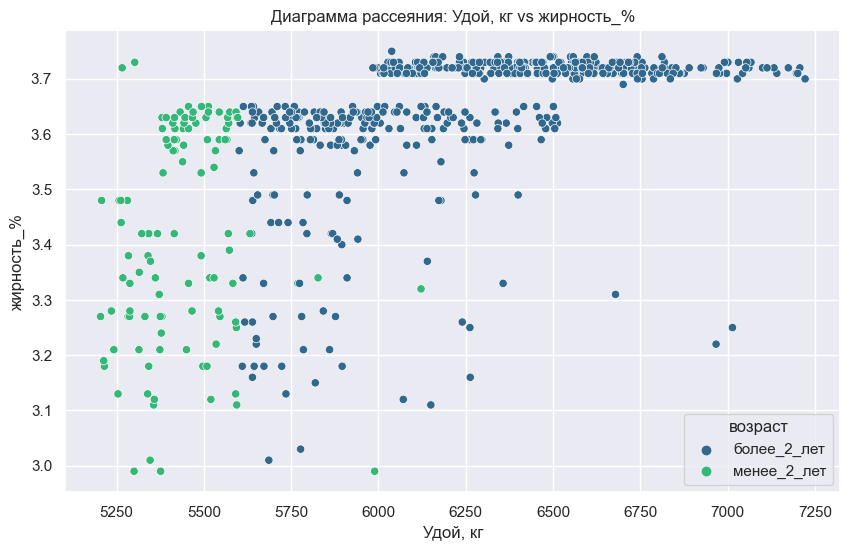

'Существует положительная корреляция (средняя) между удоем и жирность_% для категории более_2_лет (коэффициент: 0.49).'

'Существует положительная корреляция (низкая) между удоем и жирность_% для категории менее_2_лет (коэффициент: 0.10).'

'Тип зависимости между удоем и жирность_%: нелинейная (стандартное отклонение остатков: 0.13, стандартное отклонение жирность_%: 0.17, стандартное отклонение остатков больше 10% (79.93%) от стандартного отклонения жирность_%).'

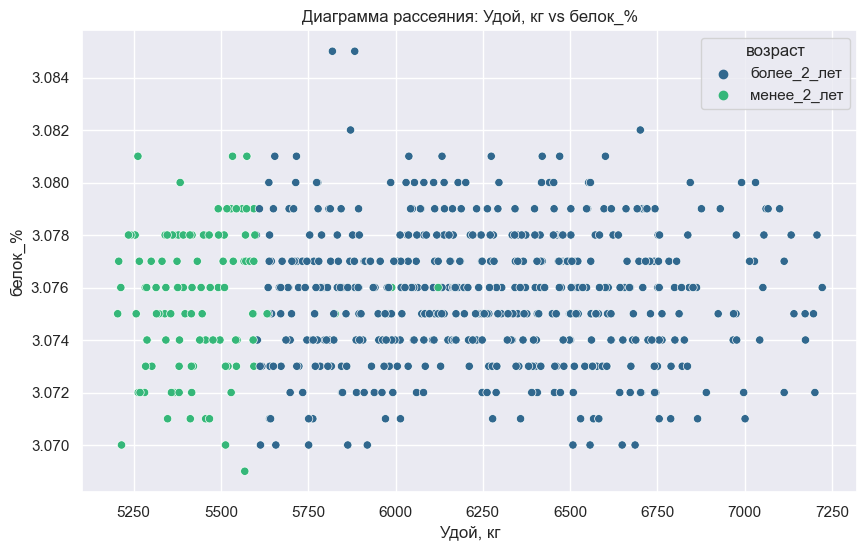

'Существует отрицательная корреляция (низкая) между удоем и белок_% для категории более_2_лет (коэффициент: -0.02).'

'Существует положительная корреляция (низкая) между удоем и белок_% для категории менее_2_лет (коэффициент: 0.10).'

'Тип зависимости между удоем и белок_%: нелинейная (стандартное отклонение остатков: 0.00, стандартное отклонение белок_%: 0.00, стандартное отклонение остатков больше 10% (100.00%) от стандартного отклонения белок_%).'

'Средние значения по категориям:'

возраст  удой_кг   эке  сырой_протеин_г  спо  жирность_%  белок_%
0  более_2_лет  6267.00 15.00             1928 0.93        3.64     3.08
1  менее_2_лет  5435.50 12.90             1786 0.88        3.42     3.08

'Наиболее выгодная категория по удою: более_2_лет с удоем 6267.00 кг.'

In [49]:
categorical_col = 'возраст'
get_scatterplot(categorical_col)

Выводы:  
Повышение качества корма очень сильно влияет на коров старше 2 лет  
В то время как, на молодых коров нет смысла тратить более качественный корм  
Более выгодным будут коровы старше 2 лет

## Выводы

Обобщая все вышеизложенное, можем приоритезировать следующие признаки:  
Порода - РефлешнСоверинг  
Тип пастбища - холмистое  
Порода папы быка - Айдиал  
Возраст - более 2 лет  

А так же, что чем выше качества корма - тем лучше

<div class="alert alert-info"> <b>Комментарий студента_1:</b> Дописал выводы в функцию с расчетам зависимости <p>
    Не совсем понимаю про мультиколлинеарность здесь, если мы уже это обсудили в матрице корреляции и выяснили, что подобных признаков нет. <p>
</div>

# Обучение модели линейной регрессии

## Подготовьте данные датасета ferma_main.csv

Признаки для линейной регрессии:  

ЭКЕ (Энергетическая кормовая единица) - напрямую влияет на питательную ценность корма, что может сказываться на удое. Более высокие значения эке предполагают лучшее питание, что может привести к увеличению удоя.  
Сырой протеин (г) - является ключевым компонентом рациона коров, необходимым для роста и производства молока. Увеличение содержания протеина в рационе может привести к повышению удоя.  
СПО (Сахаро-протеиновое соотношение) - влияет на питательную ценность. Более высокие значения могут способствовать увеличению удоя.  
Возраст - может влиять на её продуктивность. Более зрелые коровы могут иметь более высокий удой, хотя это также зависит от других факторов, таких как здоровье и генетика.  
Порода и порода папы быка - могут влиять на удой, это категориальные признаки, которые требуют дополнительной обработки.  
Тип пастбища - также может влиять на качество корма.  

Признаки, которые не подходят:  
  
Жирность (%) - жирность молока это признак вкуса молока и никак не влияет на удой.  
Белок (%) - аналогично жирности.  
Вкус молока - вкус молока не является количественным признаком и не имеет прямой связи с удоем. Это скорее субъективная оценка.

т.к. в дальнейшем нас ждет 3 модели с одними и темиже действиями - подготовим функции и переменные

In [50]:
# кодируем данные
def get_new_encode_base(data, categorical_features, quantitative_features):
    categorical_features = [col for col in categorical_features if col in data.columns]
    quantitative_features = [col for col in quantitative_features if col in data.columns]
    encoder = OneHotEncoder(drop='first', sparse=False)
    encoded_categorical = encoder.fit_transform(data[categorical_features])
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names(categorical_features))
    dataframe_encoded = pd.concat([data[quantitative_features].reset_index(drop=True), encoded_df], axis=1)
    
    return dataframe_encoded

In [51]:
# выделяем целевой признак
def get_target(data, target):
    # сохранение входных признаков в переменную X
    X = data.drop(target, axis=1)
    # сохранение целевого признака в переменную y
    y = data[target]
    return X, y

In [52]:
# масштабирование количественных признаков
def get_scaler(dataframe_encoded):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dataframe_encoded)
    return data_scaled

In [53]:
# разделение на тренировочную и тестовую выборки
def get_data_split(data_scaled, y):
    RANDOM_STATE = 10
    X_train, X_test, y_train, y_test = train_test_split(
        data_scaled, 
        y, 
        random_state=RANDOM_STATE,
        test_size=0.2
    )
    return X_train, X_test, y_train, y_test

In [54]:
# обучение модели линейной регрессии
def get_model_lin_reg(X_test, y_test):
    model_lr = LinearRegression()
    model_lr.fit(X_test, y_test)

    # получение предсказаний
    predictions = model_lr.predict(X_test)

    # выбор случайных индексов
    random_indices = np.random.choice(len(y_test), size=2, replace=False)

    # вывод случайных предсказаний и реальных значений
    display("Проверим как обучилась модель:")
    for index in random_indices:
        display(f"Реальное значение: {y_test.iloc[index]}, Предсказанное значение: {predictions[index]}")

    return model_lr

In [55]:
# обучение модели линейной регрессии
def get_model_log_reg(X_train, y_train):
    model_lr = LogisticRegression()
    model_lr.fit(X_train, y_train)

    # получение предсказаний
    predictions = model_lr.predict(X_train)

    # выбор 3 случайных индексов
    random_indices = np.random.choice(len(y_train), size=3, replace=False)

    # вывод случайных предсказаний и реальных значений
    display("Проверим как обучилась модель:")
    for index in random_indices:
        display(f"Реальное значение: {y_train.iloc[index]}, Предсказанное значение: {predictions[index]}")

    return model_lr

In [56]:
# оценка качества модели на тестовой выборке
def get_r2(model_lr, X_test, y_test):
    r_squared = model_lr.score(X_test, y_test)
    return r_squared

In [57]:
# получение mae
def get_mae(model, X, y_true):
    # получение предсказаний
    y_pred = model.predict(X)
    
    # расчет MAE
    mae = mean_absolute_error(y_true, y_pred)
    return mae

In [58]:
# получение mse
def get_mse(model, X, y_true):
    # получение предсказаний
    y_pred = model.predict(X)
    
    # расчет MSE
    mse = mean_squared_error(y_true, y_pred)
    return mse

In [59]:
# получение rmse
def get_rmse(model, X, y_true):
    # получение предсказаний
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y_true, y_pred)
    
    # Расчет RMSE
    rmse = np.sqrt(mse)
    return rmse

In [60]:
# анализ остатков
def get_rest(model_lr, X_test, y_test):
    y_pred = model_lr.predict(X_test)
    residuals = y_test - y_pred

    # создаем фигуру с двумя подграфиками
    plt.figure(figsize=(14, 6))
    
    # гистограмма остатков
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=30)
    plt.axvline(np.mean(residuals), color='red', linestyle='--', label='Среднее')
    plt.title('Гистограмма остатков')
    plt.xlabel('Остатки')
    plt.ylabel('Частота')
    plt.legend()
    
    # график остатков
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--', label='Среднее')
    plt.title('Анализ остатков')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')

    plt.tight_layout()  # улучшает расположение подграфиков
    plt.show()

In [61]:
def calculate_prediction_interval(model, X_train, X_test, y_test, quantiles=(0.025, 0.975)):
    # получение предсказаний на тестовых данных
    y_pred_test = model.predict(X_test)
    
    # вычисление ошибок
    errors = y_test - y_pred_test
    
    # рассчет квантилей ошибок
    lower_quantile = np.quantile(errors, quantiles[0])
    upper_quantile = np.quantile(errors, quantiles[1])
    
    # вывод доверительного интервала
    return lower_quantile, upper_quantile

In [62]:
# accuracy
def calculate_accuracy(y_true, y_pred):
    # Вывод метрик
    accuracy = accuracy_score(y_true, y_pred)
    display(f'Accuracy: {accuracy:.2f} - говорит о точности предсказания модели, т.е. {accuracy:.2f} правильных предсказаний')
    return accuracy_score(y_true, y_pred)

In [63]:
# recall
def calculate_recall(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    display(f'Recall: {recall:.2f} - это доля правильно предсказанных положительных случаев (вкусно) среди всех реальных положительных случаев.')
    return recall

In [64]:
# precision
def calculate_precision(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    display(f'Precision: {precision:.2f} - это доля правильно предсказанных положительных случаев среди всех предсказанных положительных случаев.')
    return precision_score(y_true, y_pred)

In [65]:
# матрица ошибок
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['TF', 'TP'], yticklabels=['NF', 'NP'])
    plt.ylabel('Реальные')
    plt.xlabel('Предсказанные')
    plt.title('Матрица ошибок')
    plt.show()

## Обучите первую модель LinearRegression

In [66]:
# целевой признак
target = 'удой_кг'
# категориальные признаки
categorical_features = ['возраст']
# количественные признаки
# убурем из расчетов 'жирность_%', 'белок_%', т.к. это показатели молока, а не его объема
quantitative_features = ['удой_кг', 'эке', 'сырой_протеин_г', 'спо', ]

# кодируем категориальные признаки
ferma_lr_1 = get_new_encode_base(ferma_main, categorical_features, quantitative_features)

# делим на целевой и входные признаки
X, y = get_target(ferma_lr_1, target)

# стандартизируем базу
ferma_lr_1 = get_scaler(X)

# разделим на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = get_data_split(ferma_lr_1, y)

'Проверим как обучилась модель:'

'Реальное значение: 6584, Предсказанное значение: 6584.62455450887'

'Реальное значение: 5785, Предсказанное значение: 5800.222004482632'

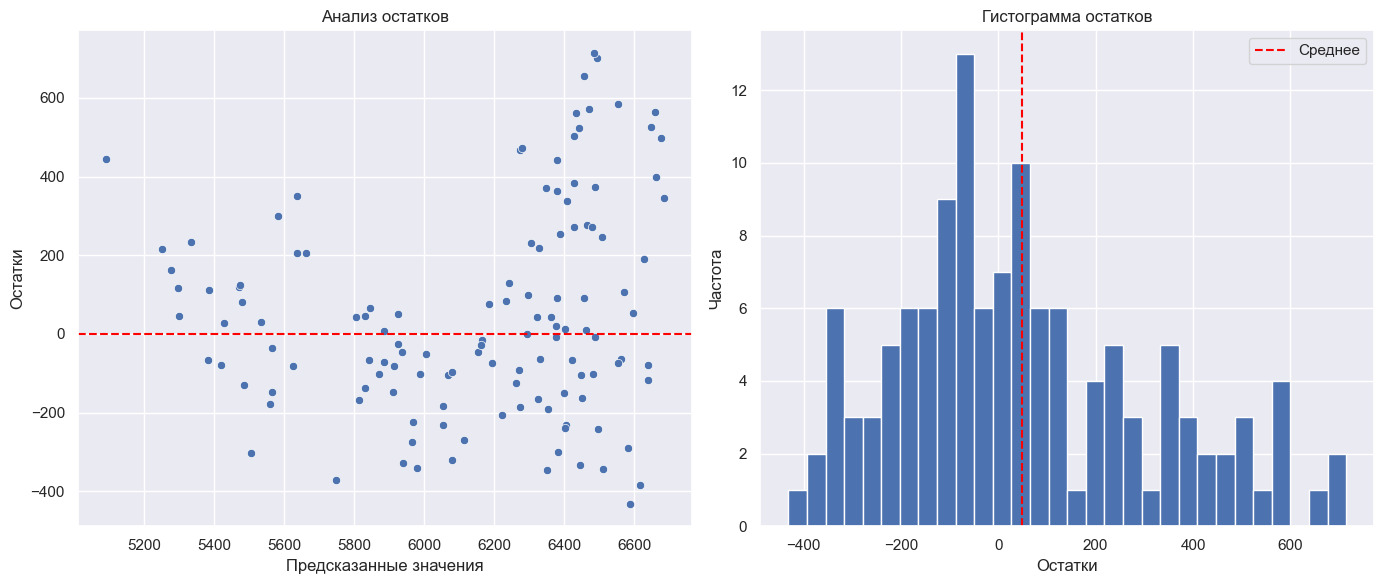

'r2_1 - 0.7288609768380114'

'mae_1 - 207.90539543635825'

'mse_1 - 71429.27197796333'

'rmse_1 - 267.2625525171144'

In [67]:
model_lr_1 = get_model_lin_reg(X_train, y_train)
get_rest(model_lr_1, X_test, y_test)
r2_1 = get_r2(model_lr_1, X_test, y_test)
display(f"r2_1 - {r2_1}")
mae_1 = get_mae(model_lr_1, X_test, y_test)
display(f"mae_1 - {mae_1}")
mse_1 = get_mse(model_lr_1, X_test, y_test)
display(f"mse_1 - {mse_1}")
rmse_1 = get_rmse(model_lr_1, X_test, y_test)
display(f"rmse_1 - {rmse_1}")

Среднее отклонение в предсказания ~207кг, в разрезе года - неплохой показатель  
Графики остатков говорят о неоднородном распределении, что также указывает на недостаточный уровень обученния модели  

## Обучите вторую модель LinearRegression

СПО и Удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение СПО, которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуйте СПО в категориальный бинарный признак, использовав эту границу.

на графике мы видим четкое разграничение по линии СПО = 0.92 - на нем и остановимся

In [68]:
# сделаем новую переменную под вторую модель 
ferma_lr_2 = ferma_main
spo_target = 0.92
ferma_lr_2['спо_категория'] = (ferma_lr_2['спо'] > spo_target).astype(int)
display(ferma_lr_2.sample(5))

id  удой_кг   эке  сырой_протеин_г  спо           порода тип_пастбища  \
433  435     6573 15.60             1815 0.94  РефлешнСоверинг    равнинное   
592  594     7174 16.70             2318 0.95  РефлешнСоверинг    холмистое   
292  294     6663 14.90             2317 0.95  РефлешнСоверинг    холмистое   
428  430     6139 13.90             1853 0.94  РефлешнСоверинг    холмистое   
590  592     5520 11.90             1785 0.88   Вис Бик Айдиал    равнинное   

    порода_папы_быка  жирность_%  белок_% вкус_молока      возраст  \
433          Соверин        3.73     3.08      вкусно  более_2_лет   
592           Айдиал        3.72     3.07      вкусно  более_2_лет   
292          Соверин        3.72     3.08      вкусно  более_2_лет   
428           Айдиал        3.61     3.08      вкусно  более_2_лет   
590          Соверин        3.12     3.07   не вкусно  менее_2_лет   

     спо_категория  
433              1  
592              1  
292              1  
428              1  
590              0

ЭКЕ и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате

In [69]:
ferma_lr_2['эке_square'] = ferma_main['эке']**2
display(ferma_lr_2.sample(5))

id  удой_кг   эке  сырой_протеин_г  спо           порода тип_пастбища  \
441  443     6755 15.20             1785 0.93  РефлешнСоверинг    холмистое   
489  491     5842 13.20             1836 0.85  РефлешнСоверинг    холмистое   
410  412     5805 13.40             1999 0.88   Вис Бик Айдиал    холмистое   
592  594     7174 16.70             2318 0.95  РефлешнСоверинг    холмистое   
606  608     5639 13.40             1668 0.88   Вис Бик Айдиал    холмистое   

    порода_папы_быка  жирность_%  белок_% вкус_молока      возраст  \
441           Айдиал        3.70     3.08   не вкусно  более_2_лет   
489           Айдиал        3.28     3.08      вкусно  более_2_лет   
410          Соверин        3.59     3.08   не вкусно  более_2_лет   
592           Айдиал        3.72     3.07      вкусно  более_2_лет   
606          Соверин        3.64     3.08   не вкусно  более_2_лет   

     спо_категория  эке_square  
441              1      231.04  
489              0      174.24  
410              0      179.56  
592              1      278.89  
606              0      179.56

In [70]:
# построим модель с новыми вводными
# целевой признак
target = 'удой_кг'
# категориальные признаки
categorical_features = ['возраст']
# количественные признаки
quantitative_features = ['удой_кг', 'эке_square', 'сырой_протеин_г', 'спо_категория']

# кодируем категориальные признаки
ferma_lr_2 = get_new_encode_base(ferma_lr_2, categorical_features, quantitative_features)

# делим на целевой и входные признаки
X, y = get_target(ferma_lr_2, target)

# стандартизируем базу
ferma_lr_2 = get_scaler(X)

# разделим на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = get_data_split(ferma_lr_2, y)

'Проверим как обучилась модель:'

'Реальное значение: 5374, Предсказанное значение: 5398.785531758361'

'Реальное значение: 5412, Предсказанное значение: 5381.611316791103'

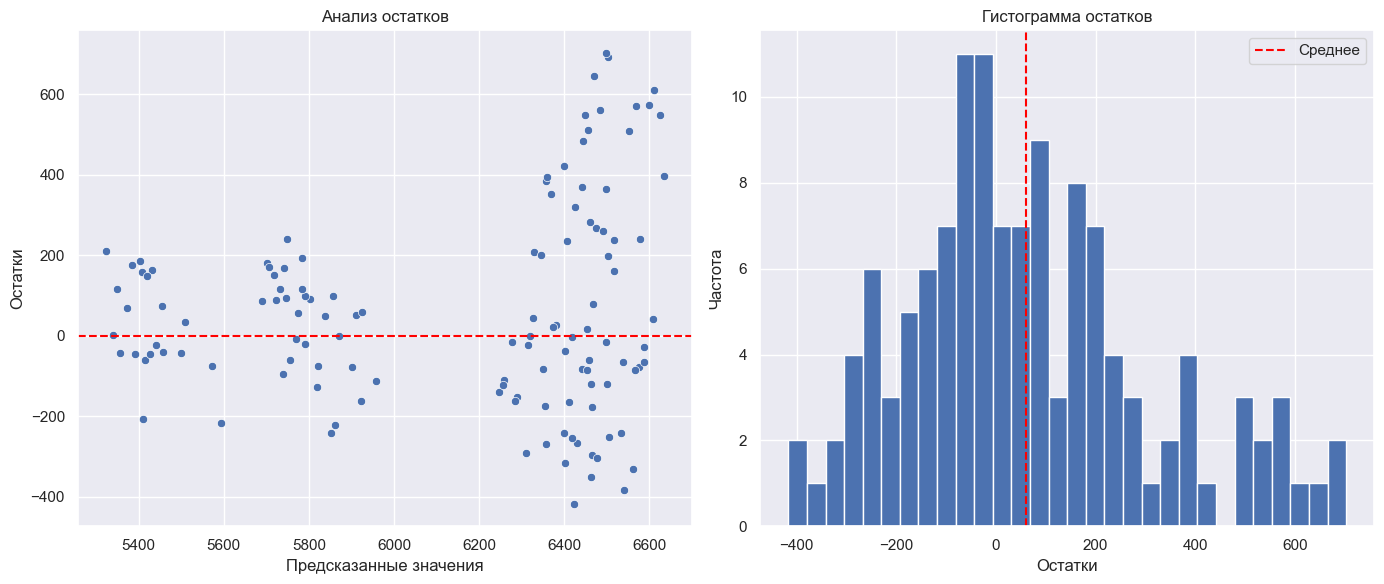

'r2_2 - 0.7546531543500976'

'mae_2 - 192.9559740186561'

'mse_2 - 64634.54195006155'

'rmse_2 - 254.23324320407343'

In [71]:
model_lr_2 = get_model_lin_reg(X_train, y_train)
get_rest(model_lr_2, X_test, y_test)
r2_2 = get_r2(model_lr_2, X_test, y_test)
display(f"r2_2 - {r2_2}")
mae_2 = get_mae(model_lr_2, X_test, y_test)
display(f"mae_2 - {mae_2}")
mse_2 = get_mse(model_lr_2, X_test, y_test)
display(f"mse_2 - {mse_2}")
rmse_2 = get_rmse(model_lr_2, X_test, y_test)
display(f"rmse_2 - {rmse_2}")

Стало немного, но лучше!  

Ошибка по весу удоя ~193 кг  

## Обучите третью модель LinearRegression

Добавьте признак Имя Папы из файла ferma_dad.csv, соединив его с остальными данными ferma_main.csv по ключу.  
Устраните нелинейность между признаками.

In [72]:
# сделаем новую переменную под третью модель 
ferma_lr_3 = ferma_main

In [73]:
# объединим базы и добавим новый признак имя папы из файла ferma_dad.csv
ferma_lr_3 = ferma_lr_3.merge(
    ferma_dad, 
    left_on='id', 
    right_on='id', 
    how='inner' # мы удаляли выброс, поэтому скопируем только то, что есть
)
display(ferma_lr_3.sample(5))

id  удой_кг   эке  сырой_протеин_г  спо           порода тип_пастбища  \
85    87     5564 13.40             1883 0.89   Вис Бик Айдиал    холмистое   
96    98     6262 15.10             1985 0.93   Вис Бик Айдиал    равнинное   
433  435     6573 15.60             1815 0.94  РефлешнСоверинг    равнинное   
33    35     5356 12.90             1734 0.89   Вис Бик Айдиал    равнинное   
19    21     6752 15.50             1924 0.93  РефлешнСоверинг    холмистое   

    порода_папы_быка  жирность_%  белок_% вкус_молока      возраст  \
85            Айдиал        3.61     3.08      вкусно  менее_2_лет   
96           Соверин        3.25     3.08   не вкусно  более_2_лет   
433          Соверин        3.73     3.08      вкусно  более_2_лет   
33            Айдиал        3.11     3.08   не вкусно  менее_2_лет   
19            Айдиал        3.73     3.08      вкусно  более_2_лет   

     спо_категория  эке_square  имя_папы  
85               0      179.56     Барин  
96               1      228.01     Барин  
433              1      243.36     Барин  
33               0      166.41  Соловчик  
19               1      240.25    Буйный

In [74]:
# сделаем 3ю модель
# целевой признак
target = 'удой_кг'
# категориальные признаки
categorical_features = ['возраст', 'имя_папы']
# количественные признаки
quantitative_features = ['удой_кг', 'эке_square', 'сырой_протеин_г', 'спо_категория']

# кодируем категориальные признаки
ferma_lr_3 = get_new_encode_base(ferma_lr_3, categorical_features, quantitative_features)

# делим на целевой и входные признаки
X, y = get_target(ferma_lr_3, target)

# стандартизируем базу
ferma_lr_3 = get_scaler(X)

# разделим на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = get_data_split(ferma_lr_3, y)

'Проверим как обучилась модель:'

'Реальное значение: 5961, Предсказанное значение: 5791.551160576576'

'Реальное значение: 5450, Предсказанное значение: 5748.202658770577'

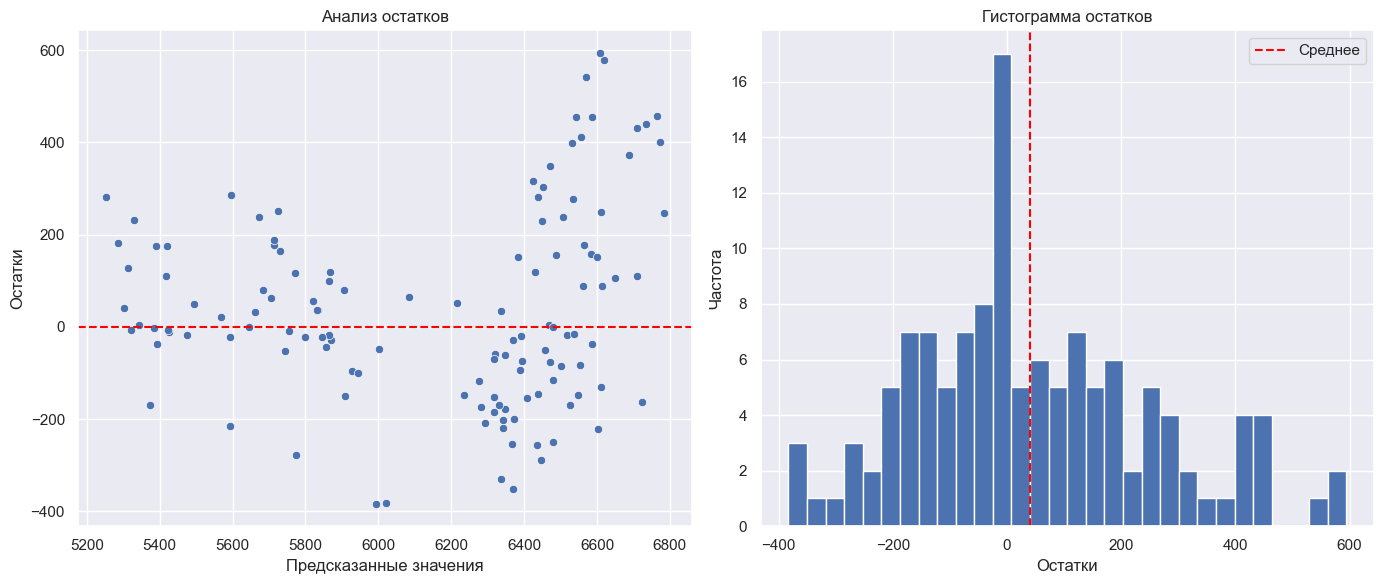

'r2_3 - 0.827373133347538'

'mae_3 - 164.43627738874903'

'mse_3 - 45477.081332758'

'rmse_3 - 213.25356112561872'

In [75]:
model_lr_3 = get_model_lin_reg(X_train, y_train)
get_rest(model_lr_3, X_test, y_test)
r2_3 = get_r2(model_lr_3, X_test, y_test)
display(f"r2_3 - {r2_3}")
mae_3 = get_mae(model_lr_3, X_test, y_test)
display(f"mae_3 - {mae_3}")
mse_3 = get_mse(model_lr_3, X_test, y_test)
display(f"mse_3 - {mse_3}")
rmse_3 = get_rmse(model_lr_3, X_test, y_test)
display(f"rmse_3 - {rmse_3}")

Здесь ошибка еще меньше ~164 кг

## Обучите четвертую модель LinearRegression

откуда 4я, спросишь ты?  
в эфире рубрика эксперименты - мы возьем все признаки, что у нас есть и посмотрим, что из этого выйдет :)  
пысы - искллючим только вкус молока, т.к. это единственный признак которого нет в базе покупки и его мы предскажем немного позже

In [76]:
# сделаем новую переменную под четвертую модель 
ferma_lr_4 = ferma_main
# объединим базы и добавим новый признак имя папы из файла ferma_dad.csv
ferma_lr_4 = ferma_lr_4.merge(
    ferma_dad, 
    left_on='id', 
    right_on='id', 
    how='inner' # мы удаляли выброс, поэтому скопируем только то, что есть
)
display(ferma_lr_4.sample(5))

id  удой_кг   эке  сырой_протеин_г  спо           порода тип_пастбища  \
507  509     6498 16.50             2123 0.94  РефлешнСоверинг    холмистое   
201  203     6112 16.40             1871 0.94   Вис Бик Айдиал    равнинное   
382  384     5268 12.50             1889 0.89  РефлешнСоверинг    холмистое   
178  180     6478 15.40             1799 0.94   Вис Бик Айдиал    равнинное   
486  488     6005 13.50             1842 0.94  РефлешнСоверинг    равнинное   

    порода_папы_быка  жирность_%  белок_% вкус_молока      возраст  \
507          Соверин        3.70     3.07      вкусно  более_2_лет   
201          Соверин        3.72     3.08      вкусно  более_2_лет   
382          Соверин        3.34     3.07      вкусно  менее_2_лет   
178           Айдиал        3.71     3.08      вкусно  более_2_лет   
486           Айдиал        3.62     3.07   не вкусно  более_2_лет   

     спо_категория  эке_square  имя_папы  
507              1      272.25  Соловчик  
201              1      268.96  Соловчик  
382              0      156.25     Барин  
178              1      237.16    Буйный  
486              1      182.25    Буйный

In [77]:
# сделаем 4ю модель
# целевой признак
target = 'удой_кг'
# категориальные признаки
categorical_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
# количественные признаки
quantitative_features = ['удой_кг', 'эке_square', 'сырой_протеин_г', 'спо_категория', 'жирность_%', 'белок_%']

# кодируем категориальные признаки
ferma_lr_4 = get_new_encode_base(ferma_lr_4, categorical_features, quantitative_features)
display(ferma_lr_4.head())

# делим на целевой и входные признаки
X, y = get_target(ferma_lr_4, target)

# стандартизируем базу
ferma_lr_4 = get_scaler(X)
display(ferma_lr_4.shape)

# разделим на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = get_data_split(ferma_lr_4, y)

удой_кг  эке_square  сырой_протеин_г  спо_категория  жирность_%  белок_%  \
0     5863      201.64             1743              0        3.58     3.08   
1     5529      163.84             2138              0        3.54     3.08   
2     5810      196.00             1854              0        3.59     3.07   
3     5895      153.76             2012              0        3.40     3.08   
4     5302      163.84             1675              0        3.73     3.07   

   порода_РефлешнСоверинг  тип_пастбища_холмистое  порода_папы_быка_Соверин  \
0                    0.00                    0.00                      0.00   
1                    0.00                    0.00                      1.00   
2                    1.00                    1.00                      1.00   
3                    1.00                    1.00                      0.00   
4                    0.00                    0.00                      1.00   

   возраст_менее_2_лет  имя_папы_Буйный  имя_папы_Геркулес  имя_папы_Соловчик  
0                 0.00             1.00               0.00               0.00  
1                 1.00             0.00               0.00               1.00  
2                 0.00             0.00               0.00               0.00  
3                 0.00             1.00               0.00               0.00  
4                 1.00             0.00               0.00               0.00

(628, 12)

'Проверим как обучилась модель:'

'Реальное значение: 5573, Предсказанное значение: 5236.2782339245105'

'Реальное значение: 6660, Предсказанное значение: 6437.908394189437'

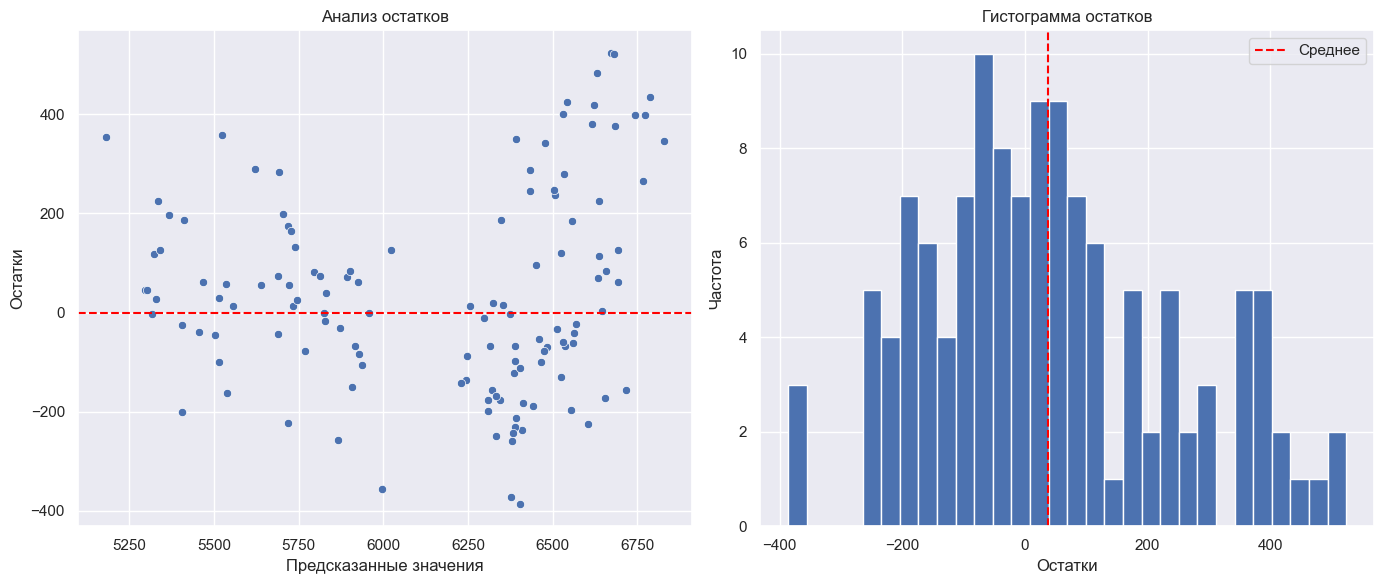

'r2_4 - 0.8398099011529341'

'mae_4 - 160.73642671809822'

'mse_4 - 42200.72052073399'

'rmse_4 - 205.42813955428304'

In [78]:
model_lr_4 = get_model_lin_reg(X_train, y_train)
get_rest(model_lr_4, X_test, y_test)
r2_4 = get_r2(model_lr_4, X_test, y_test)
display(f"r2_4 - {r2_4}")
mae_4 = get_mae(model_lr_4, X_test, y_test)
display(f"mae_4 - {mae_4}")
mse_4 = get_mse(model_lr_4, X_test, y_test)
display(f"mse_4 - {mse_4}")
rmse_4 = get_rmse(model_lr_4, X_test, y_test)
display(f"rmse_4 - {rmse_4}")

ошибка по удою 160 кг и это, кажется, лучший вариант

## Обучите пятую модель LinearRegression

In [79]:
# сделаем новую переменную под пятую модель 
ferma_lr_5 = ferma_main
# объединим базы и добавим новый признак имя папы из файла ferma_dad.csv
ferma_lr_5 = ferma_lr_5.merge(
    ferma_dad, 
    left_on='id', 
    right_on='id', 
    how='inner' # мы удаляли выброс, поэтому скопируем только то, что есть
)

In [80]:
# сделаем 5ю модель
# целевой признак
target = 'удой_кг'
# категориальные признаки
categorical_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
# количественные признаки
# а тут все таки уберем лишние признаки которые никак не влияют на удой
quantitative_features = ['удой_кг', 'эке_square', 'сырой_протеин_г', 'спо_категория']

# кодируем категориальные признаки
ferma_lr_5 = get_new_encode_base(ferma_lr_5, categorical_features, quantitative_features)

# делим на целевой и входные признаки
X, y = get_target(ferma_lr_5, target)

# стандартизируем базу
ferma_lr_5 = get_scaler(X)

# разделим на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = get_data_split(ferma_lr_5, y)

'Проверим как обучилась модель:'

'Реальное значение: 5638, Предсказанное значение: 5690.191086222855'

'Реальное значение: 6582, Предсказанное значение: 6410.174054972258'

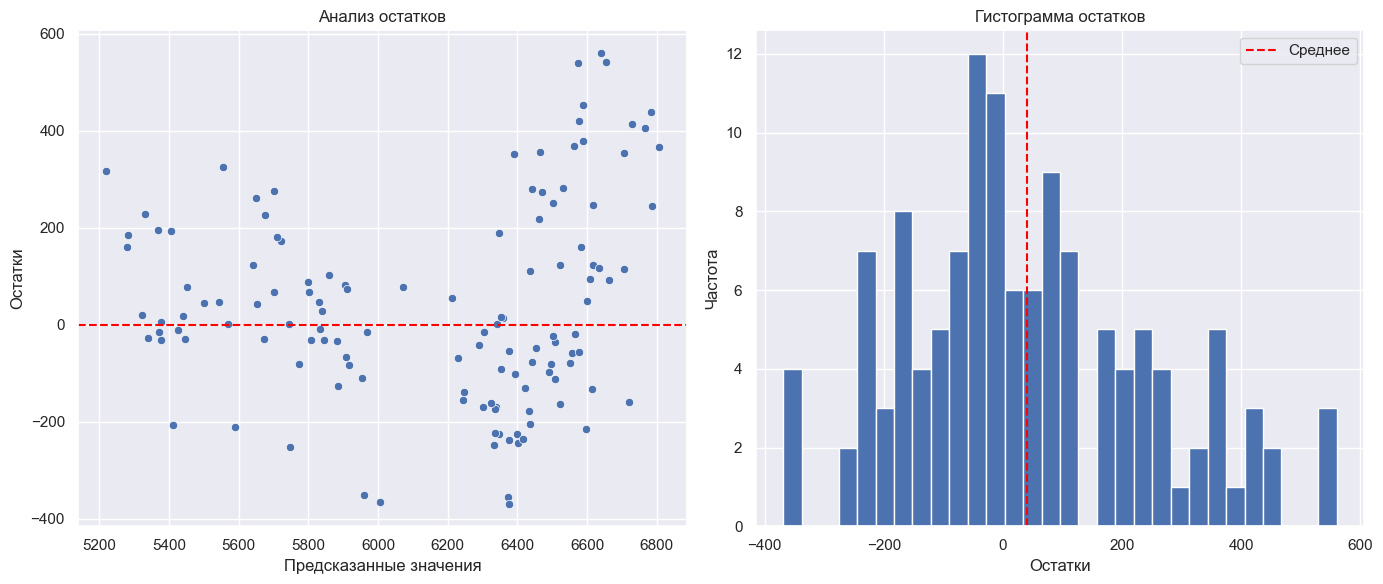

'r2_5 - 0.8345799489611412'

'mae_5 - 162.02303621695918'

'mse_5 - 43578.5069905043'

'rmse_5 - 208.7546574103301'

In [81]:
model_lr_5 = get_model_lin_reg(X_train, y_train)
get_rest(model_lr_5, X_test, y_test)
r2_5 = get_r2(model_lr_5, X_test, y_test)
display(f"r2_5 - {r2_5}")
mae_5 = get_mae(model_lr_5, X_test, y_test)
display(f"mae_5 - {mae_5}")
mse_5 = get_mse(model_lr_5, X_test, y_test)
display(f"mse_5 - {mse_5}")
rmse_5 = get_rmse(model_lr_5, X_test, y_test)
display(f"rmse_5 - {rmse_5}")

гипотеза не оправдала себя, ошибка в удое увеличилась

## Сравните качество моделей линейной регрессии, сопоставьте их R² и остатки.  Оцените качество каждой модели по трём метрикам: MSE, MAE, RMSE.  

In [82]:
result_data = pd.DataFrame({
    'Model': ['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5'],
    'R2': [r2_1, r2_2, r2_3, r2_4, r2_5],
    'MAE': [mae_1, mae_2, mae_3, mae_4, mae_5],
    'MSE': [mse_1, mse_2, mse_3, mse_4, mse_5],
    'RMSE': [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5]
})

result_data.set_index('Model', inplace=True)

display(result_data)

R2    MAE      MSE   RMSE
Model                              
Model_1 0.73 207.91 71429.27 267.26
Model_2 0.75 192.96 64634.54 254.23
Model_3 0.83 164.44 45477.08 213.25
Model_4 0.84 160.74 42200.72 205.43
Model_5 0.83 162.02 43578.51 208.75

По всем признакам - 4я модель обученная на всех входных признаках справляется лучше остальных

## Укажите доверительный интервал прогноза лучшей модели. Для этого рассчитайте квантили ошибки модели на тренировочных данных.

In [83]:
X_train, X_test, y_train, y_test = get_data_split(ferma_lr_4, y)
lower_bound, upper_bound = calculate_prediction_interval(model_lr_4, X_train, X_test, y_test, quantiles=(0.025, 0.975))
display(f"Доверительный интервал прогноза: [{lower_bound}, {upper_bound}]")

'Доверительный интервал прогноза: [-258.93461663687594, 433.3324654346451]'

Таким образом, чтобы отобрать коров которые гарантированно дадут 6000кг, нам нужны из списка предсказаний те, у которых будет результат 6000 + 259.93

## С помощью лучшей модели спрогнозируйте удой коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv

### Добавьте недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение): возьмите из датасета ferma_main.csv средние значения каждого из признаков и увеличьте их на 5%.

In [84]:
cow_buy['эке'] = ferma_main['эке'] * 1.05
cow_buy['сырой_протеин_г'] = ferma_main['сырой_протеин_г'] * 1.05
cow_buy['спо'] = ferma_main['спо'] * 1.05

In [85]:
display(cow_buy)

порода тип_пастбища порода_папы_быка  имя_папы  жирность_%  \
0    Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.58   
1    Вис Бик Айдиал    равнинное          Соверин    Буйный        3.54   
2   РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
3   РефлешнСоверинг    холмистое           Айдиал    Буйный        3.40   
4   РефлешнСоверинг    равнинное           Айдиал    Буйный        3.64   
5   РефлешнСоверинг    равнинное          Соверин  Геркулес        3.63   
6    Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.58   
7    Вис Бик Айдиал    равнинное          Соверин    Буйный        3.57   
8   РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
9   РефлешнСоверинг    холмистое           Айдиал    Буйный        3.40   
10   Вис Бик Айдиал    холмистое          Соверин  Соловчик        3.73   
11  РефлешнСоверинг    равнинное          Соверин  Геркулес        3.73   
12   Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.68   
13   Вис Бик Айдиал    холмистое          Соверин     Барин        3.42   
14  РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
15  РефлешнСоверинг    холмистое           Айдиал    Буйный        3.40   
16   Вис Бик Айдиал    холмистое          Соверин  Соловчик        3.73   
17  РефлешнСоверинг    равнинное          Соверин  Геркулес        3.77   
18   Вис Бик Айдиал    равнинное          Соверин    Буйный        3.34   
19  РефлешнСоверинг    равнинное           Айдиал    Буйный        3.64   

    белок_%      возраст   эке  сырой_протеин_г  спо  
0      3.08  более_2_лет 14.91          1830.15 0.93  
1      3.08  менее_2_лет 13.44          2244.90 0.93  
2      3.07  более_2_лет 14.70          1946.70 0.93  
3      3.06  более_2_лет 13.02          2112.60 0.93  
4      3.07  более_2_лет 13.44          1758.75 0.93  
5      3.05  менее_2_лет 13.33          1896.30 0.93  
6      3.08  более_2_лет 13.86          1881.60 0.93  
7      3.08  более_2_лет 15.44          1896.30 0.98  
8      3.07  более_2_лет 14.91          2013.90 0.99  
9      3.08  менее_2_лет 14.07          1880.55 0.94  
10     3.06  более_2_лет 14.38          1761.90 0.94  
11     3.07  более_2_лет 17.32          2444.40 0.98  
12     3.05  более_2_лет 16.17          2302.65 0.98  
13     3.08  менее_2_лет 15.23          1854.30 0.98  
14     3.07  более_2_лет 16.80          1857.45 0.98  
15     3.06  более_2_лет 16.38          1834.35 0.98  
16     3.08  более_2_лет 13.02          1966.65 0.94  
17     3.05  менее_2_лет 16.48          2266.95 0.98  
18     3.07  более_2_лет 15.02          1846.95 0.94  
19     3.07  более_2_лет 16.28          2020.20 0.98

### Выполните подготовку данных, аналогичную той, которую делали для тренировочной выборки.

In [86]:
# сделаем спо_категория
cow_predict_yield = cow_buy
spo_target = 0.92
cow_predict_yield['спо_категория'] = (cow_predict_yield['спо'] > spo_target).astype(int)

In [87]:
# исключаем нелинейность
cow_predict_yield['эке_square'] = cow_predict_yield['эке'] ** 2
display(cow_predict_yield.sample(1))

порода тип_пастбища порода_папы_быка  имя_папы  жирность_%  \
11  РефлешнСоверинг    равнинное          Соверин  Геркулес        3.73   

    белок_%      возраст   эке  сырой_протеин_г  спо  спо_категория  \
11     3.07  более_2_лет 17.32          2444.40 0.98              1   

    эке_square  
11      300.16

In [88]:
# подготовим все с чистого листа для предсказаний
ferma_lr = ferma_main
# объединим базы и добавим новый признак имя папы из файла ferma_dad.csv
ferma_lr = ferma_lr.merge(
    ferma_dad, 
    left_on='id', 
    right_on='id', 
    how='inner' # мы удаляли выброс, поэтому скопируем только то, что есть
)

# целевой признак
target = 'удой_кг'
# категориальные признаки
categorical_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
# количественные признаки
quantitative_features = ['удой_кг', 'эке_square', 'сырой_протеин_г', 'спо_категория', 'жирность_%', 'белок_%']

# кодируем категориальные признаки
ferma_lr = get_new_encode_base(ferma_lr, categorical_features, quantitative_features)

# делим на целевой и входные признаки
X, y = get_target(ferma_lr, target)

# стандартизируем базу
ferma_lr = get_scaler(X)

# разделим на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = get_data_split(ferma_lr, y)
model_lr = get_model_lin_reg(X_train, y_train)

# попробуем сделать предсказания
# количественные признаки немного будут отличаться, у нас же нет удоя в базе для покупки
quantitative_features = ['эке_square', 'сырой_протеин_г', 'спо_категория', 'жирность_%', 'белок_%']

# кодируем категориальные признаки
cow_predict_yield_encoded = get_new_encode_base(cow_predict_yield, categorical_features, quantitative_features)

# стандартизируем с использованием того же скейлера
cow_predict_yield_scaled = get_scaler(cow_predict_yield_encoded)  # Получаем скейлер на тренировочных данных

# Получение предсказаний
predictions = model_lr.predict(cow_predict_yield_scaled)

# Добавляем предсказания в DataFrame
cow_predict_yield['предсказанный_удой_кг'] = predictions

# Просмотр результата
display(format_display("База на покупку с добавление предсказаний удоя"))
display(cow_predict_yield)
display(f"Итого подходящих, по удою, на покупку коров: {cow_predict_yield[cow_predict_yield['предсказанный_удой_кг'] >= (6000 + 258.93)].shape[0]} из {cow_predict_yield.shape[0]}")

'Проверим как обучилась модель:'

'Реальное значение: 7028, Предсказанное значение: 6759.074084578061'

'Реальное значение: 5492, Предсказанное значение: 5394.610343691775'

порода тип_пастбища порода_папы_быка  имя_папы  жирность_%  \
0    Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.58   
1    Вис Бик Айдиал    равнинное          Соверин    Буйный        3.54   
2   РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
3   РефлешнСоверинг    холмистое           Айдиал    Буйный        3.40   
4   РефлешнСоверинг    равнинное           Айдиал    Буйный        3.64   
5   РефлешнСоверинг    равнинное          Соверин  Геркулес        3.63   
6    Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.58   
7    Вис Бик Айдиал    равнинное          Соверин    Буйный        3.57   
8   РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
9   РефлешнСоверинг    холмистое           Айдиал    Буйный        3.40   
10   Вис Бик Айдиал    холмистое          Соверин  Соловчик        3.73   
11  РефлешнСоверинг    равнинное          Соверин  Геркулес        3.73   
12   Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.68   
13   Вис Бик Айдиал    холмистое          Соверин     Барин        3.42   
14  РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
15  РефлешнСоверинг    холмистое           Айдиал    Буйный        3.40   
16   Вис Бик Айдиал    холмистое          Соверин  Соловчик        3.73   
17  РефлешнСоверинг    равнинное          Соверин  Геркулес        3.77   
18   Вис Бик Айдиал    равнинное          Соверин    Буйный        3.34   
19  РефлешнСоверинг    равнинное           Айдиал    Буйный        3.64   

    белок_%      возраст   эке  сырой_протеин_г  спо  спо_категория  \
0      3.08  более_2_лет 14.91          1830.15 0.93              1   
1      3.08  менее_2_лет 13.44          2244.90 0.93              1   
2      3.07  более_2_лет 14.70          1946.70 0.93              1   
3      3.06  более_2_лет 13.02          2112.60 0.93              1   
4      3.07  более_2_лет 13.44          1758.75 0.93              1   
5      3.05  менее_2_лет 13.33          1896.30 0.93              1   
6      3.08  более_2_лет 13.86          1881.60 0.93              1   
7      3.08  более_2_лет 15.44          1896.30 0.98              1   
8      3.07  более_2_лет 14.91          2013.90 0.99              1   
9      3.08  менее_2_лет 14.07          1880.55 0.94              1   
10     3.06  более_2_лет 14.38          1761.90 0.94              1   
11     3.07  более_2_лет 17.32          2444.40 0.98              1   
12     3.05  более_2_лет 16.17          2302.65 0.98              1   
13     3.08  менее_2_лет 15.23          1854.30 0.98              1   
14     3.07  более_2_лет 16.80          1857.45 0.98              1   
15     3.06  более_2_лет 16.38          1834.35 0.98              1   
16     3.08  более_2_лет 13.02          1966.65 0.94              1   
17     3.05  менее_2_лет 16.48          2266.95 0.98              1   
18     3.07  более_2_лет 15.02          1846.95 0.94              1   
19     3.07  более_2_лет 16.28          2020.20 0.98              1   

    эке_square  предсказанный_удой_кг  
0       222.31                6149.45  
1       180.63                5911.37  
2       216.09                5962.27  
3       169.52                6115.03  
4       180.63                6027.98  
5       177.82                5861.79  
6       192.10                6061.46  
7       238.24                6214.46  
8       222.31                6000.05  
9       197.96                5920.76  
10      206.93                6037.42  
11      300.16                6569.37  
12      261.47                6489.91  
13      231.80                5801.27  
14      282.24                6160.86  
15      268.30                6365.49  
16      169.52                5907.37  
17      271.76                6296.36  
18      225.45                6138.78  
19      264.88                6375.70

'Итого подходящих, по удою, на покупку коров: 5 из 20'

## Выводы

Подготовили данные и обучили несколько моделей предсказания удоя.  
Лучше всего себя показала модель которая использовала все возможные признаки.  
На этой модели провели предсказания на база продаваемых коров - получилось 13 коров, которые дадут удой более чем 6000 кг в год

# Задача классификации

## Подготовьте данные датасета ferma_main.csv и обучите на них модель LogisticRegression

In [89]:
# эке возведен в квадрат (но для нового признака будет использовать исходные данные) и введен признак спо_категория
# добавим имя папы
# и сразу сделаем новые признаки качество_корма и качество_молока, сравним потом 2 модели на исходных и новых признаках
ferma_for_lr_class = ferma_main
ferma_for_lr_class['качество_корма'] = (ferma_for_lr_class['эке'] + ferma_for_lr_class['сырой_протеин_г'] + ferma_for_lr_class['спо']) / 3
ferma_for_lr_class['качество_молока'] = (ferma_for_lr_class['жирность_%'] + ferma_for_lr_class['белок_%']) / 2
display(ferma_for_lr_class.sample(2))

id  удой_кг   эке  сырой_протеин_г  спо           порода тип_пастбища  \
55    57     5643 13.40             2041 0.90  РефлешнСоверинг    холмистое   
131  133     6267 13.90             2246 0.94   Вис Бик Айдиал    холмистое   

    порода_папы_быка  жирность_%  белок_% вкус_молока      возраст  \
55            Айдиал        3.53     3.08      вкусно  более_2_лет   
131          Соверин        3.73     3.08      вкусно  более_2_лет   

     спо_категория  эке_square  качество_корма  качество_молока  
55               0      179.56          685.10             3.30  
131              1      193.21          753.61             3.40

### Проверим на исходных данных

In [90]:
# изменим значения столбца вкус_молока на 0 и 1 (вкусно и не вкусно), т.к. у нас это целевой показатель и нам надо будет его предсказать
ferma_for_lr_class['вкус_молока'] = ferma_for_lr_class['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)
display(ferma_for_lr_class.sample(2))

id  удой_кг   эке  сырой_протеин_г  спо          порода тип_пастбища  \
39    41     6400 14.60             1824 0.93  Вис Бик Айдиал    холмистое   
393  395     6351 14.90             2231 0.93  Вис Бик Айдиал    холмистое   

    порода_папы_быка  жирность_%  белок_%  вкус_молока      возраст  \
39            Айдиал        3.49     3.08            0  более_2_лет   
393          Соверин        3.72     3.08            0  более_2_лет   

     спо_категория  эке_square  качество_корма  качество_молока  
39               1      213.16          613.18             3.28  
393              1      222.01          748.94             3.40

In [91]:
# целевой признак
target = 'вкус_молока'
# категориальные признаки какие могут влиять на вкус
categorical_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
# количественные признаки какие могут влиять на вкус
quantitative_features = ['вкус_молока', 'эке_square', 'сырой_протеин_г', 'спо_категория', 'жирность_%', 'белок_%']

In [92]:
ferma_lr_class_1 = get_new_encode_base(ferma_for_lr_class, categorical_features, quantitative_features)
X, y = get_target(ferma_lr_class_1, target)
X_scaled = get_scaler(X)
X_train, X_test, y_train, y_test = get_data_split(X_scaled, y)
model_lr_class_1 = get_model_log_reg(X_train, y_train)

'Проверим как обучилась модель:'

'Реальное значение: 1, Предсказанное значение: 1'

'Реальное значение: 1, Предсказанное значение: 1'

'Реальное значение: 1, Предсказанное значение: 0'

'Accuracy: 0.65 - говорит о точности предсказания модели, т.е. 0.65 правильных предсказаний'

'Recall: 0.74 - это доля правильно предсказанных положительных случаев (вкусно) среди всех реальных положительных случаев.'

'Precision: 0.72 - это доля правильно предсказанных положительных случаев среди всех предсказанных положительных случаев.'

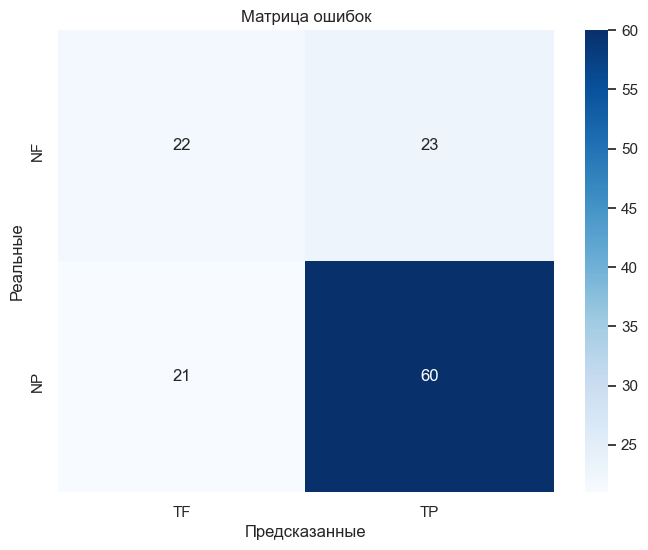

In [93]:
# вероятности предсказаний
predictions_proba = model_lr_class_1.predict_proba(X_test)[:, 1]

# порог
threshold = 0.5
y_pred_binary = (predictions_proba >= threshold).astype(int)

# расчитаем метрики
accuracy = calculate_accuracy(y_test, y_pred_binary)
recall = calculate_recall(y_test, y_pred_binary)
precision = calculate_precision(y_test, y_pred_binary)

# и построим матрицу ошибок
plot_confusion_matrix(y_test, y_pred_binary)

получилось что, 23 ложно положительных, и 60 верных предсказания.  
нам надо свети к 0 ложно полжительные и чтобы верные были больше 0  

In [94]:
# определяем пороги от 0.1 до 1 с шагом 0.1
thresholds = np.arange(0.1, 1.1, 0.1)

# подберем значение порога
porog = None

for threshold in thresholds:
    y_pred_threshold = (predictions_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_threshold)
    
    if cm[0][1] == 0:
        precision = precision_score(y_test, y_pred_threshold)
        print('Порог =', threshold, 'Precision =', round(precision, 2), 'TP =', cm[1][1])
        porog = threshold
        break

Порог = 0.8 Precision = 1.0 TP = 8


'Accuracy: 0.43 - говорит о точности предсказания модели, т.е. 0.43 правильных предсказаний'

'Recall: 0.11 - это доля правильно предсказанных положительных случаев (вкусно) среди всех реальных положительных случаев.'

'Precision: 1.00 - это доля правильно предсказанных положительных случаев среди всех предсказанных положительных случаев.'

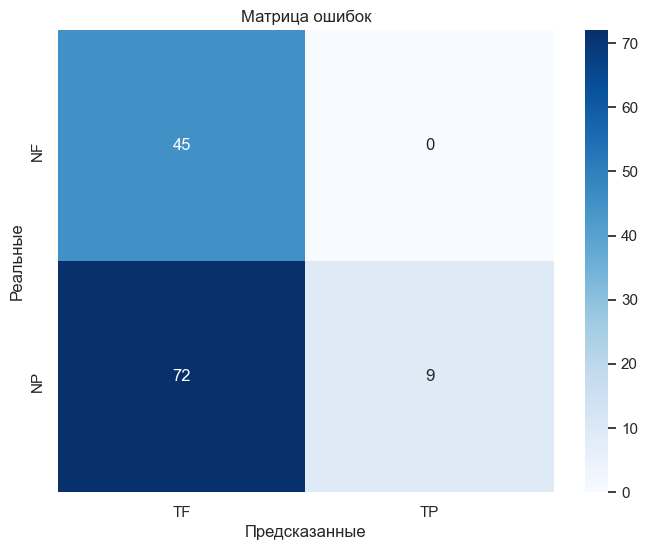

In [95]:
# проверим
# вероятности предсказаний
predictions_proba = model_lr_class_1.predict_proba(X_test)[:, 1]

# порог
threshold = 0.78
y_pred_binary = (predictions_proba >= threshold).astype(int)

# расчитаем метрики
accuracy = calculate_accuracy(y_test, y_pred_binary)
recall = calculate_recall(y_test, y_pred_binary)
precision = calculate_precision(y_test, y_pred_binary)

# и построим матрицу ошибок
plot_confusion_matrix(y_test, y_pred_binary)

На деле же, получилось в ручную немного скорректировать порог и повысить качество модели

И получается, что 9 коров подходит для нас из тестовой выборки...   
С учетом того, что коров у нас 628, то такой себе результат, проверим, что там с коровами на продажу  

### Проверим на обобщенных данных

In [96]:
# целевой признак
target = 'вкус_молока'
# категориальные признаки какие могут влиять на вкус
categorical_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
# количественные признаки какие могут влиять на вкус
quantitative_features = ['вкус_молока', 'качество_корма', 'качество_молока', 'спо_категория']

In [97]:
ferma_lr_class_2 = get_new_encode_base(ferma_for_lr_class, categorical_features, quantitative_features)
X, y = get_target(ferma_lr_class_2, target)
X_scaled = get_scaler(X)
X_train, X_test, y_train, y_test = get_data_split(X_scaled, y)
model_lr_class_2 = get_model_log_reg(X_train, y_train)

'Проверим как обучилась модель:'

'Реальное значение: 1, Предсказанное значение: 0'

'Реальное значение: 1, Предсказанное значение: 0'

'Реальное значение: 0, Предсказанное значение: 1'

'Accuracy: 0.70 - говорит о точности предсказания модели, т.е. 0.70 правильных предсказаний'

'Recall: 0.84 - это доля правильно предсказанных положительных случаев (вкусно) среди всех реальных положительных случаев.'

'Precision: 0.73 - это доля правильно предсказанных положительных случаев среди всех предсказанных положительных случаев.'

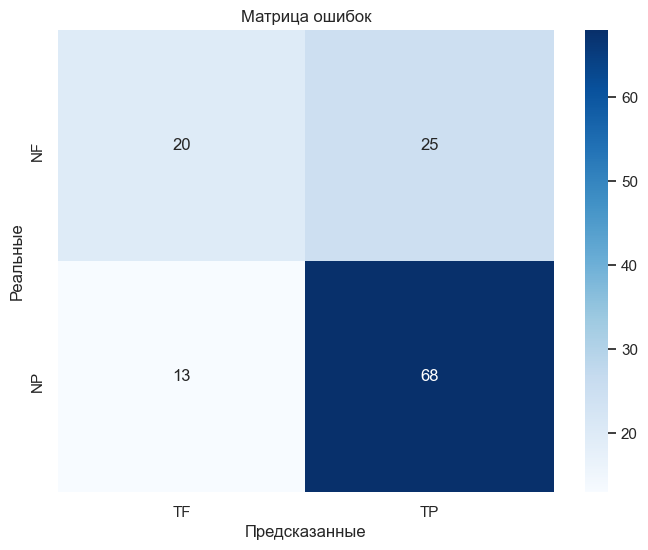

In [98]:
# вероятности предсказаний
predictions_proba = model_lr_class_2.predict_proba(X_test)[:, 1]

# порог
threshold = 0.5
y_pred_binary = (predictions_proba >= threshold).astype(int)

# расчитаем метрики
accuracy = calculate_accuracy(y_test, y_pred_binary)
recall = calculate_recall(y_test, y_pred_binary)
precision = calculate_precision(y_test, y_pred_binary)

# и построим матрицу ошибок
plot_confusion_matrix(y_test, y_pred_binary)

получилось что, 25 ложно положительных, и 68 верных предсказания.  
нам надо свети к 0 ложно полжительные и чтобы верные были больше 0  

In [99]:
# определяем пороги от 0.1 до 1 с шагом 0.1
thresholds = np.arange(0.1, 1.1, 0.1)

# подберем значение порога
porog = None

for threshold in thresholds:
    y_pred_threshold = (predictions_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_threshold)
    
    if cm[0][1] == 0:
        precision = precision_score(y_test, y_pred_threshold)
        print('Порог =', threshold, 'Precision =', round(precision, 2), 'TP =', cm[1][1])
        porog = threshold
        break

Порог = 0.7000000000000001 Precision = 1.0 TP = 16


'Accuracy: 0.50 - говорит о точности предсказания модели, т.е. 0.50 правильных предсказаний'

'Recall: 0.22 - это доля правильно предсказанных положительных случаев (вкусно) среди всех реальных положительных случаев.'

'Precision: 1.00 - это доля правильно предсказанных положительных случаев среди всех предсказанных положительных случаев.'

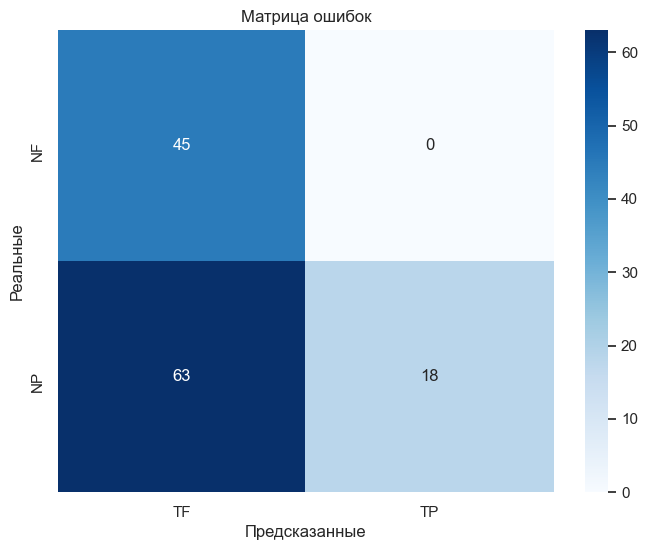

In [100]:
# проверим
# вероятности предсказаний
predictions_proba = model_lr_class_2.predict_proba(X_test)[:, 1]

# порог
threshold = 0.695
y_pred_binary = (predictions_proba >= threshold).astype(int)

# расчитаем метрики
accuracy = calculate_accuracy(y_test, y_pred_binary)
recall = calculate_recall(y_test, y_pred_binary)
precision = calculate_precision(y_test, y_pred_binary)

# и построим матрицу ошибок
plot_confusion_matrix(y_test, y_pred_binary)

На деле же, получилось в ручную немного скорректировать порог и повысить качество модели

И получается, что 18 коров подходит для нас из тестовой выборки...   
С учетом того, что коров у нас 628, то такой себе результат, проверим, что там с коровами на продажу  

Таким образом, обобщение исходных признаков в новые и уменьшение размерности базы дал прирост качества в 2 раза (было 9 коров с вкусным молоком, а стало 18)

## С помощью обученной модели спрогнозируйте вкус молока коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv.

In [101]:
# проверим предсказание
# целевой признак
target = 'вкус_молока'
# категориальные признаки какие могут влиять на вкус
categorical_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
# количественные признаки какие могут влиять на вкус
quantitative_features = ['вкус_молока', 'качество_корма', 'качество_молока', 'спо_категория']

ferma_lr_class = get_new_encode_base(ferma_for_lr_class, categorical_features, quantitative_features)
X, y = get_target(ferma_lr_class, target)
X_scaled = get_scaler(X)
X_train, X_test, y_train, y_test = get_data_split(X_scaled, y)
model_lr_class = get_model_log_reg(X_train, y_train)

cow_predict_milk = cow_predict_yield
cow_predict_milk['качество_корма'] = (cow_predict_yield['эке'] + cow_predict_yield['сырой_протеин_г'] + cow_predict_yield['спо']) / 3
cow_predict_milk['качество_молока'] = (cow_predict_yield['жирность_%'] + cow_predict_yield['белок_%']) / 2
display(cow_predict_milk.sample(2))

# попробуем сделать предсказания
quantitative_features = ['качество_корма', 'качество_молока', 'спо_категория']

# кодируем категориальные признаки
cow_predict_milk_encoded = get_new_encode_base(cow_predict_milk, categorical_features, quantitative_features)

# стандартизируем с использованием того же скейлера
cow_predict_milk_scaled = get_scaler(cow_predict_milk_encoded)  # Получаем скейлер на тренировочных данных

# получение вероятностей предсказаний
predictions_proba = model_lr_class.predict_proba(cow_predict_milk_scaled)[:, 1]

# применяем порог для бинаризации предсказаний
threshold = 0.695
predictions = (predictions_proba >= threshold).astype(int)

# добавляем предсказания в DataFrame
cow_predict_milk['предсказанный_вкус_молока'] = predictions

# просмотр результата
display(format_display("База на покупку с добавление предсказаний вкуса молока"))
display(cow_predict_milk)
display(f"Итого подходящих, по вкусу, на покупку коров: {cow_predict_milk[cow_predict_milk['предсказанный_вкус_молока'] == 1].shape[0]} из {cow_predict_milk.shape[0]}")

'Проверим как обучилась модель:'

'Реальное значение: 1, Предсказанное значение: 0'

'Реальное значение: 1, Предсказанное значение: 1'

'Реальное значение: 1, Предсказанное значение: 1'

порода тип_пастбища порода_папы_быка  имя_папы  жирность_%  \
14  РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
16   Вис Бик Айдиал    холмистое          Соверин  Соловчик        3.73   

    белок_%      возраст   эке  сырой_протеин_г  спо  спо_категория  \
14     3.07  более_2_лет 16.80          1857.45 0.98              1   
16     3.08  более_2_лет 13.02          1966.65 0.94              1   

    эке_square  предсказанный_удой_кг  качество_корма  качество_молока  
14      282.24                6160.86          625.08             3.33  
16      169.52                5907.37          660.20             3.40

порода тип_пастбища порода_папы_быка  имя_папы  жирность_%  \
0    Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.58   
1    Вис Бик Айдиал    равнинное          Соверин    Буйный        3.54   
2   РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
3   РефлешнСоверинг    холмистое           Айдиал    Буйный        3.40   
4   РефлешнСоверинг    равнинное           Айдиал    Буйный        3.64   
5   РефлешнСоверинг    равнинное          Соверин  Геркулес        3.63   
6    Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.58   
7    Вис Бик Айдиал    равнинное          Соверин    Буйный        3.57   
8   РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
9   РефлешнСоверинг    холмистое           Айдиал    Буйный        3.40   
10   Вис Бик Айдиал    холмистое          Соверин  Соловчик        3.73   
11  РефлешнСоверинг    равнинное          Соверин  Геркулес        3.73   
12   Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.68   
13   Вис Бик Айдиал    холмистое          Соверин     Барин        3.42   
14  РефлешнСоверинг    равнинное          Соверин     Барин        3.59   
15  РефлешнСоверинг    холмистое           Айдиал    Буйный        3.40   
16   Вис Бик Айдиал    холмистое          Соверин  Соловчик        3.73   
17  РефлешнСоверинг    равнинное          Соверин  Геркулес        3.77   
18   Вис Бик Айдиал    равнинное          Соверин    Буйный        3.34   
19  РефлешнСоверинг    равнинное           Айдиал    Буйный        3.64   

    белок_%      возраст   эке  сырой_протеин_г  спо  спо_категория  \
0      3.08  более_2_лет 14.91          1830.15 0.93              1   
1      3.08  менее_2_лет 13.44          2244.90 0.93              1   
2      3.07  более_2_лет 14.70          1946.70 0.93              1   
3      3.06  более_2_лет 13.02          2112.60 0.93              1   
4      3.07  более_2_лет 13.44          1758.75 0.93              1   
5      3.05  менее_2_лет 13.33          1896.30 0.93              1   
6      3.08  более_2_лет 13.86          1881.60 0.93              1   
7      3.08  более_2_лет 15.44          1896.30 0.98              1   
8      3.07  более_2_лет 14.91          2013.90 0.99              1   
9      3.08  менее_2_лет 14.07          1880.55 0.94              1   
10     3.06  более_2_лет 14.38          1761.90 0.94              1   
11     3.07  более_2_лет 17.32          2444.40 0.98              1   
12     3.05  более_2_лет 16.17          2302.65 0.98              1   
13     3.08  менее_2_лет 15.23          1854.30 0.98              1   
14     3.07  более_2_лет 16.80          1857.45 0.98              1   
15     3.06  более_2_лет 16.38          1834.35 0.98              1   
16     3.08  более_2_лет 13.02          1966.65 0.94              1   
17     3.05  менее_2_лет 16.48          2266.95 0.98              1   
18     3.07  более_2_лет 15.02          1846.95 0.94              1   
19     3.07  более_2_лет 16.28          2020.20 0.98              1   

    эке_square  предсказанный_удой_кг  качество_корма  качество_молока  \
0       222.31                6149.45          615.33             3.33   
1       180.63                5911.37          753.09             3.31   
2       216.09                5962.27          654.11             3.33   
3       169.52                6115.03          708.85             3.23   
4       180.63                6027.98          591.04             3.36   
5       177.82                5861.79          636.85             3.34   
6       192.10                6061.46          632.13             3.33   
7       238.24                6214.46          637.57             3.32   
8       222.31                6000.05          676.60             3.33   
9       197.96                5920.76          631.85             3.24   
10      206.93                6037.42          592.41             3.39   
11      300.16                6569.37          820.90    

'Итого подходящих, по вкусу, на покупку коров: 2 из 20'

Момент истины... сколько же коров мы можем порекомендовать фермеру?

In [102]:
all_cow = cow_predict_milk.shape[0]
# 6258.93 = целевые 6000 и нижний доверительный интервал 258.93
true_cows = cow_predict_milk[(cow_predict_milk['предсказанный_удой_кг'] > 6258.93) & (cow_predict_milk['предсказанный_вкус_молока'] == 1)]
true_cows_count = true_cows.shape[0]

# Выводим отфильтрованные строки
display(true_cows)
display(f"Итого подходящих, по удою и вкусу, на покупку коров: {true_cows_count} из {all_cow}")


порода тип_пастбища порода_папы_быка  имя_папы  жирность_%  \
12  Вис Бик Айдиал    холмистое           Айдиал  Геркулес        3.68   

    белок_%      возраст   эке  сырой_протеин_г  спо  спо_категория  \
12     3.05  более_2_лет 16.17          2302.65 0.98              1   

    эке_square  предсказанный_удой_кг  качество_корма  качество_молока  \
12      261.47                6489.91          773.27             3.36   

    предсказанный_вкус_молока  
12                          1

'Итого подходящих, по удою и вкусу, на покупку коров: 1 из 20'

## Выводы

В этой части мы также подготовили данные, но для предсказания качества молока использовали только те признаки которые подходят логически.  
Дополнительно обобщили имеющиеся признаки в качество корма и качество молока на выходе.  
На этих данных получили предсказания, которые максимально устраивали бы фермера, т.е. пусть и мало, но он точно может быть уверен, что коровы дадут вкусное молоко и получилось, что такая корова одна.

# Итоговые выводы

В ходе работы мы обработали полученные от фермера и продавца данные о коровах:  
- привели к нормальному виду данные;  
- удалили ошибочные данные;  
- расчитали актуальные показатели качества корма для коров продавца;  

Анализ данных о коровах от фермера показал следующее:  
удой - зависит от показателей возраст, эке, спо, порода_папы_быка;  
вкус молока - зависит только от спо;  

После обработки данных подготовили несколько предсказательных моделей, опираясь на влияющие на результат признаки, как для предсказания удоя коров на продажу, так и для определения вкуса молока.  

После получения моделей - были выбраны лучшие, для последующей оценки продаваемых коров.  
К сожалению для фермера, вывод неутешительные - мы можем рекомендовать только 1 корову, которая будет довать больше 6000кг молока в год и оно будет вкусным.  

Можем посоветовать ему обратиться к другим разводчикам коров и уже там проверить.

Тем не менее и без моделей, можем приоритезировать следующие признаки:  
Порода - РефлешнСоверинг  
Тип пастбища - холмистое  
Порода папы быка - Айдиал  
Возраст - более 2 лет  
А так же можем обратить внимание на то, что, чем выше качества корма - тем лучше.